# Data Engineering Notebook

This notebook explores the relationship between the distance an outfielder needs to travel to catch ball and the amount of time that they have to cover that distance. This work is heavily influenced by Tom Tango's work in *[The History of Fielding](http://tangotiger.com/images/uploads/History_of_the_Fielding.pdf)*.

<div style="border:2px solid red; padding:10px; background-color:#ffe6e6;">
  <h2 style="color:red;">DO NOT EXECUTE CELLS</h2>
  <p>Due to the nature of the data being proprietary, the database and a raw data files are not included with this project. This notebook will not be able to be executed due to it relying soley on interacting with the raw data and database storing that data. However, provided in the data directory of this project are csv files that contain the data that was cleaned, engineered, and aggregated. These csv files allow for the other notebooks within this project to be executed, such as the <strong>Modeling</strong> and <strong>Analysis</strong> notebooks.</p>
</div>

## Table of Contents

[**Setup**](#Setup)

[**Imports**](#Imports)

[**Defined Functions**](#Defined-Functions)

[**Data Extraction**](#Data-Extraction)

[**Extract Play Details**](#Extract-Play-Details)

[**Syncing Timestamps**](#Syncing-Timestamps)

[**Extracting Player and Ball Position Data**](#Extracting-Player-and-Ball-Position-Data)

[**Calculating Player and Route Distances**](#Calculating-Player-and-Route-Distances)

[**Data Exploration**](#Data-Exploration)

[**Hangtime and Distance**](#Hangtime-and-Distance)

[**Player Attribution**](#Player-Atrribution)

[**Feature Engineering**](#Feature-Engineering)

[**Top Route Speed and Total Distance**](#Top-Route-Speed-and-Total-Distance)

[**Aggregated Speed and Distance Metrics**](#Aggregated-Speed-and-Distance-Metrics)

[**Intensity**](#Intensity)

[**Bring the Data Together**](#Bring-the-Data-Together)

[**Data Dictionary**](#Data-Dictionary)

## Setup

### Imports

In [1]:
import os
import pandas as pd
import pyarrow as pa
import numpy as np
import duckdb as db
import matplotlib.pyplot as plt
import seaborn as sns

### Defined Functions

In [2]:
def queryDB(query):
    """
    Function that takes string as a query for the database.
    Input: String query.
    Output: Dataframe of table produced by query.
    """
    # Get the path to the database.
    script_dir = os.getcwd()
    db_path = os.path.join(script_dir, 'data', 'smt_2025.db')

    # Run query.
    with db.connect(db_path) as con:
        df = con.sql(query).df()
    
    return df

def getPlayDetails(df):
    """
    Used to aggregate details from plays in the game_events table.
    Input:  A dataframe grouped by the play_key (combined game_str and play_id).
    Output: A series containing the position of player, timestamps for hit and result,
            hangtime of ball in the air, boolean of caught ball, and boolean of 
            if a throw was made during the play.
    """
    
    # Ensure that the play contains a hit. Filtering out throwdowns to outfield or data mismatches.
    if 4 not in df['event_code'].values:
            return pd.Series({'player_position': -1,
                              'timestamp_pitch': -1,
                              'timestamp_hit': -1,
                              'timestamp_result' : -1,
                              'hangtime': -1, 
                              'catch': False}) 
    
    # Get timestamps for when ball is put into play and timestamp for the result.
    timestamp_pitch = df.iloc[0]['timestamp']
    timestamp_hit = df.iloc[1]['timestamp']
    timestamp_result = df.iloc[2]['timestamp']

    # Calculate the hangtime.
    hangtime = timestamp_result - timestamp_hit

    # Get result of the ball in play.
    result =  df.iloc[2]['event_code']

    # Check if the ball was caught.
    if result == 2:
        catch = True
    else:
        catch = False

    # Get which player got to the ball first / caught the ball.
    acquires = df[df['event_code'] == 2].iloc[0]['player_position']

    # If more than one acquire, get the first one.
    if isinstance(acquires, list):
        player = acquires[0]
    else:
        player = acquires


    return pd.Series({'player_position': player,
                      'timestamp_pitch': timestamp_pitch,
                      'timestamp_hit': timestamp_hit,
                      'timestamp_result' : timestamp_result,
                      'hangtime': hangtime, 
                      'catch': catch})

## Data Extraction

### Extract Play Details

Using this table with the whole `game_events` table will yield a table that has the plays where the outfielders are involved in the play. Then information about the play can be extracted, such as which player was first to the ball, and whether the ball was caught or not.

To make aggregations possible a unique key will be given to each `game_str` and `play_id` combination. This will be done by combining the `game_str` and `play_id`. For example, the `game_str` of y1_d069_ACN_QEA and `play_id` of 9 would have a `play_key` of y1_d069_ACN_QEA_9.

After the unique `play_keys` are known, the individual play events can be extracted.

In [3]:
# Query to get the plays that have an outfielder acquiring a ball.
query = """ 
-- Table that creates play_key for each play that involves an outfielder.
SELECT game_str || '_' || play_id AS play_key
FROM game_events
WHERE player_position IN (7, 8, 9) AND
      event_code == 2
GROUP BY game_str,
         play_id
"""

# Returns the unique play keys for outfield plays.
outfield_plays = queryDB(query)

# Query to get all plays that involve outfielders acquiring the ball.
query = """
-- Table that creates play_key for events in plays that involve outfielders.
SELECT ge.game_str || '_' || ge.play_id AS play_key,
       ge.player_position, 
       ge.event_code,
       ge.timestamp
FROM game_events as ge
-- Join table that has the play key for each play involving an outfielder.
JOIN (SELECT play_key
      FROM outfield_plays) AS op
ON ge.game_str || '_' || ge.play_id = op.play_key;
"""

# Returns the game events for outfield plays.
outfield_events = queryDB(query)

outfield_events

,play_key,player_position,event_code,timestamp
0,y2_d085_LFS_YJD_122,1,1,4129063
1,y2_d085_LFS_YJD_122,10,4,4129463
2,y2_d085_LFS_YJD_122,8,2,4132563
3,y2_d085_LFS_YJD_122,0,5,4132813
4,y2_d085_LFS_YJD_134,1,1,4563813
...,...,...,...,...
51917,y1_d056_KJH_RZQ_85,9,2,2762337
51918,y1_d056_KJH_RZQ_85,9,3,2763587
51919,y1_d056_KJH_RZQ_85,4,2,2764487
51920,y1_d056_KJH_RZQ_85,0,5,2765137


Now that the data is structured for aggregation, the defined function of `getPlayDetails` can be run on each play to extract the relevant information. This function will return a -1 for `player_position` where the the event code for a hit is not present. This can happen when there is a throwdown or pickoff that goes into the outfield.

In [4]:
# Group the dataframe by unique key and extract information.
outfield_play_details = outfield_events.groupby('play_key')[['player_position', 'event_code', 'timestamp']].apply(
                        lambda play: getPlayDetails(play)).reset_index()

# Filter out the plays that do not contain a hit.
outfield_play_details = outfield_play_details[outfield_play_details['player_position'] != -1]

outfield_play_details

,play_key,player_position,timestamp_pitch,timestamp_hit,timestamp_result,hangtime,catch
0,y1_d001_CGA_QEA_108,8,4090155,4090605,4094005,3400,False
1,y1_d001_CGA_QEA_114,9,4226105,4226605,4231155,4550,True
2,y1_d001_CGA_QEA_127,8,4819205,4819705,4824205,4500,True
3,y1_d001_CGA_QEA_128,7,4856155,4856555,4858655,2100,False
4,y1_d001_CGA_QEA_130,9,4913255,4913705,4916755,3050,True
...,...,...,...,...,...,...,...
6934,y2_d099_YJD_RZQ_69,8,1537044162070,1537044162470,1537044166970,4500,True
6935,y2_d099_YJD_RZQ_7,9,1537042135720,1537042136120,1537042138870,2750,False
6936,y2_d099_YJD_RZQ_81,7,1537044615470,1537044615870,1537044621270,5400,True
6937,y2_d099_YJD_RZQ_95,7,1537045054970,1537045055420,1537045055520,100,False


### Syncing Timestamps

There appear to be timestamps that have large values for their timestamp. These timestamps come from the `game_events` table, if the timestamps match in the other tables, then these timestamps should be all right for the analysis. However, it is more likely that there will be a mismatch in timestamps.

First I will check the `ball_pos` timestamps at the `pitch_timestamp`, then get all the ball positioning of all plays that involve outfielders. With the two CTEs a left join will be used to get the plays where the `pitch_timestamp` was unable to be found.

The assumption going into this is that the start of the play begins at the pitch, so the first timestamp of each `play_id` will be that of when the ball is being pitched. When the `pitch_timestamp` already exists, nothing needs to be done. Whenever there is a mismatch, a comparision of the timestamp that first occurs in the play will be made to the `pitch_timestamp` and a modifier will be determined. This modifier will be applied to the timestamps in `outfield_play_details`, effectively syncing the timestamps through the different tables.

This assumption will then be applied to the `player_pos` table as well.

In [5]:
# Query to get the plays that have mismatched timestamps from the ball position table.
query_mismatched_test = """
-- CTE table with play_keys that contain pitch timestamp.
WITH plays_in AS (SELECT bp.game_str || '_' || bp.play_id as play_key
                  FROM ball_pos AS bp
                  JOIN(SELECT play_key,
                              timestamp_pitch
                       FROM outfield_play_details) AS opd
                  ON bp.game_str || '_' || bp.play_id = opd.play_key
                  WHERE bp.timestamp = opd.timestamp_pitch),
                     
-- CTE that gets all the ball positions for outfield plays.
    of_plays AS (SELECT bp.game_str || '_' || bp.play_id as play_key
                 FROM ball_pos AS bp
                 JOIN outfield_play_details AS opd
                 ON bp.game_str || '_' || bp.play_id = opd.play_key)
-- Table of play_keys that do not contain the pitch timestamp.
SELECT DISTINCT(ofp.play_key)
FROM of_plays AS ofp
LEFT JOIN plays_in as p
ON ofp.play_key = p.play_key
WHERE p.play_key IS NULL
"""

# Returns table with play keys that are mismatched.
mismatched_plays_ball = queryDB(query_mismatched_test)

mismatched_plays_ball

,play_key
0,y1_d094_XAX_QEA_123
1,y1_d094_XAX_QEA_213
2,y1_d094_XAX_QEA_219
3,y2_d023_DMS_RZQ_215
4,y2_d023_DMS_RZQ_235
...,...
200,y2_d099_YJD_RZQ_24
201,y2_d071_DYE_YJD_45
202,y2_d071_DYE_YJD_53
203,y1_d086_CRQ_QEA_46


Out of the 6,901 observations, 205 of those observations had a mismatched timestamp. Now to take those plays and find the first timestamp that corresponds with that `play_key` to determine the modifier.

In [6]:
# Query to get the modifiers for mismatched plays.
query = """
-- CTE to get the pitch timestamp of mismatched plays from play details.
WITH ts_pitch AS (SELECT mpb.play_key,
                         opd.timestamp_pitch
                  FROM outfield_play_details AS opd
                  JOIN mismatched_plays_ball AS mpb
                  ON opd.play_key = mpb.play_key),
-- CTE to get all timestamps for the mismatched plays.
ts_mismatched AS (SELECT bp.game_str || '_' || bp.play_id AS play_key,
                         bp.timestamp AS timestamp_pitch
                  FROM ball_pos AS bp
                  JOIN mismatched_plays_ball as mpb
                  ON bp.game_str || '_' || bp.play_id = mpb.play_key),
-- CTE to get the first timestamp of each mismatched play.
ts_first AS (SELECT play_key,
                    timestamp_pitch,
                    n
             -- Table that ranks each timestamps from mismtached CTE.
             FROM (SELECT play_key,
                          timestamp_pitch,
                          ROW_NUMBER() OVER (PARTITION BY play_key 
                                             ORDER BY timestamp_pitch) AS n
                   FROM ts_mismatched) AS ts_ranked
             WHERE n = 1)
-- Table to timestamp modifier per play.
SELECT tp.play_key,
       (tf.timestamp_pitch - tp.timestamp_pitch) AS modifier
FROM ts_pitch AS tp
JOIN ts_first AS tf
ON tp.play_key = tf.play_key
"""

# Returns the modifiers for mismatched plays
ts_modifiers = queryDB(query)

ts_modifiers

,play_key,modifier
0,y1_d009_DYE_RZQ_124,1
1,y1_d009_DYE_RZQ_267,1
2,y1_d009_DYE_RZQ_8,1
3,y1_d012_IXC_QEA_167,1
4,y1_d012_IXC_QEA_33,1
...,...,...
200,y1_d094_XAX_QEA_48,1
201,y2_d023_DMS_RZQ_12,1
202,y2_d023_DMS_RZQ_205,1
203,y2_d099_YJD_RZQ_125,-1537041960222


Now that the modifers have been calculated, they can be applied to the timestamps of `outfield_play_details`.

In [7]:
# Query that adjusts the timestamps in the play details table.
query = """
-- Table that applies timestamp modifier to mismatched timestamps in outfield play details.
SELECT opd.play_key,
       opd.player_position,
       CASE 
           WHEN mod.modifier IS NOT NULL THEN (opd.timestamp_pitch + mod.modifier)
           ELSE opd.timestamp_pitch
       END AS timestamp_pitch,
       CASE
           WHEN mod.modifier IS NOT NULL THEN (opd.timestamp_hit + mod.modifier)
           ELSE opd.timestamp_hit
       END AS timestamp_hit,
       CASE
           WHEN mod.modifier IS NOT NULL THEN (opd.timestamp_result + mod.modifier)
           ELSE opd.timestamp_result
       END AS timestamp_result,
       opd.hangtime,
       opd.catch,
FROM outfield_play_details as opd
LEFT JOIN ts_modifiers AS mod
ON opd.play_key = mod.play_key
"""

# Returns the play details with adjusted timestamps.
outfield_play_details = queryDB(query)

outfield_play_details

,play_key,player_position,timestamp_pitch,timestamp_hit,timestamp_result,hangtime,catch
0,y1_d001_CGA_QEA_108,8,4090155,4090605,4094005,3400,False
1,y1_d001_CGA_QEA_114,9,4226105,4226605,4231155,4550,True
2,y1_d001_CGA_QEA_127,8,4819205,4819705,4824205,4500,True
3,y1_d001_CGA_QEA_128,7,4856155,4856555,4858655,2100,False
4,y1_d001_CGA_QEA_130,9,4913255,4913705,4916755,3050,True
...,...,...,...,...,...,...,...
6896,y2_d099_YJD_RZQ_69,8,2201848,2202248,2206748,4500,True
6897,y2_d099_YJD_RZQ_7,9,175498,175898,178648,2750,False
6898,y2_d099_YJD_RZQ_81,7,2655248,2655648,2661048,5400,True
6899,y2_d099_YJD_RZQ_95,7,3094748,3095198,3095298,100,False


Modifiers have been applied, now to check if any mismatched timestamp remain.

In [8]:
# Same query to check the mismatched plays in player position.
mismatched_plays_ball = queryDB(query_mismatched_test)

mismatched_plays_ball

,play_key


Great! All the timestamps have been synced. Now the same process will be applied to the `hit_timestamp` is in the `player_pos` table timestamps.

In [9]:
# Query to get the mismatched timestamps inside of ball position data.
query = """
-- CTE table with play_keys that contain pitch timestamp.
WITH plays_in AS (SELECT pp.game_str || '_' || CAST(pp.play_id AS INT) AS play_key
                     FROM player_pos AS pp
                     JOIN(SELECT play_key,
                                 timestamp_pitch
                          FROM outfield_play_details) AS opd
                     ON pp.game_str|| '_' || CAST(pp.play_id AS INT) = opd.play_key
                     WHERE pp.timestamp = opd.timestamp_pitch),
-- CTE that gets positions for outfield plays.
of_plays AS (SELECT pp.game_str || '_' || CAST(pp.play_id AS INT) as play_key
                 FROM player_pos AS pp
                 JOIN outfield_play_details AS opd
                 ON pp.game_str || '_' || CAST(pp.play_id AS INT) = opd.play_key)
-- Table of play_keys that do not contain the pitch timestamp.
SELECT DISTINCT(ofp.play_key)
FROM of_plays AS ofp
LEFT JOIN plays_in as p
ON ofp.play_key = p.play_key
WHERE p.play_key IS NULL
"""
# Returns plays that that have mismatched timestamp in ball positioning.
mismatched_plays_player = queryDB(query)

mismatched_plays_player

,play_key
0,y2_d046_IHI_YJD_50


Uh oh, there is one more play to examine. Let's take a look at the `game_events`, `player_pos` and our play details for this play.

In [10]:
# Query to get the game events for mismatched play.
query = """
SELECT *
FROM game_events
WHERE game_str = 'y2_d046_IHI_YJD'
      AND play_id = 50
"""

# Returns the game events for mismatched play.
mismatched_play_events = queryDB(query)

# Query to get the player position data from mismatched play.
query = """
SELECT *
FROM player_pos
WHERE game_str = 'y2_d046_IHI_YJD'
      AND play_id = 50
      AND player_position = 7
"""

# Returns the player positioning data from mismatched play.
mismatched_player_pos = queryDB(query)

# Look at the play details.
outfield_play_details[outfield_play_details['play_key'] == 'y2_d046_IHI_YJD_50']

,play_key,player_position,timestamp_pitch,timestamp_hit,timestamp_result,hangtime,catch
4011,y2_d046_IHI_YJD_50,7,1467930,1468380,1468630,250,False


In [11]:
mismatched_play_events

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,year,day
0,y2_d046_IHI_YJD,50,15,50,1467430,1,1,YJD,IHI,year_2,day_046
1,y2_d046_IHI_YJD,50,15,50,1467880,10,4,YJD,IHI,year_2,day_046
2,y2_d046_IHI_YJD,50,15,50,1468130,0,5,YJD,IHI,year_2,day_046
3,y2_d046_IHI_YJD,50,15,50,1474080,7,2,YJD,IHI,year_2,day_046
4,y2_d046_IHI_YJD,50,15,50,1474780,0,5,YJD,IHI,year_2,day_046


In [12]:
mismatched_player_pos

,game_str,play_id,timestamp,player_position,field_x,field_y,home_team,away_team,year,day
0,y2_d046_IHI_YJD,50.0,1468180.0,7.0,-137.4588,257.6532,YJD,IHI,year_2,day_046
1,y2_d046_IHI_YJD,50.0,1468230.0,7.0,-137.5347,257.5755,YJD,IHI,year_2,day_046
2,y2_d046_IHI_YJD,50.0,1468280.0,7.0,-137.6217,257.4891,YJD,IHI,year_2,day_046
3,y2_d046_IHI_YJD,50.0,1468330.0,7.0,-137.7198,257.3943,YJD,IHI,year_2,day_046
4,y2_d046_IHI_YJD,50.0,1468380.0,7.0,-137.8290,257.2914,YJD,IHI,year_2,day_046
...,...,...,...,...,...,...,...,...,...,...
128,y2_d046_IHI_YJD,50.0,1474580.0,7.0,-200.8611,174.5487,YJD,IHI,year_2,day_046
129,y2_d046_IHI_YJD,50.0,1474630.0,7.0,-200.6013,174.3309,YJD,IHI,year_2,day_046
130,y2_d046_IHI_YJD,50.0,1474680.0,7.0,-200.3382,174.1134,YJD,IHI,year_2,day_046
131,y2_d046_IHI_YJD,50.0,1474730.0,7.0,-200.0778,173.8941,YJD,IHI,year_2,day_046


Looking at the `game_events` for this play, it appears that there is an error in the game codes. This play has two end of play codes, one right after the hit and the second after the left fielder catches the ball. I will assume that the first end of play code is in error. Additionally, the timestamps from the game `player_pos` and are 250 ms greater than that of the timestamp in the play details. This modifier will be applied to the timestamp for the player position for that play.

#### Getting Timestamps per Second from Frames per Second

Part of this analysis will be getting player position data at specific points during an outfielder's route. An issue with this is that there are some routes that are recorded at 33.3 frames per second (fps) and 20 fps. This would have the timestamps between different positions be 30ms and 50ms respectively. When taking the 20th timestamp from the the moment the ball is hit, this would be 1 second after the 20 fps but only little over half a second at 33.3 fps. To keep measurements consistent, the fps of the play will need to be recorded. This will be done on a per play basis due to the data spanning over different seasons and account for tech upgrades or replacements. A feature that tracks the difference in timestamps (`msf`) will be created to track how many milliseconds are between each frame in the play.

In [13]:
# Query to get the timestamps per second.
query = """
-- CTE with timestamps for each play key.
WITH of_play_ts AS (SELECT game_str || '_' || CAST(play_id AS INT) AS play_key,
                           timestamp
                    FROM player_pos
                    WHERE (game_str || '_' || CAST(play_id AS INT), player_position) IN (SELECT play_key,
                                                                                                player_position
                                                                                         FROM outfield_play_details)),
-- CTE that gets the marginal timestamps.
lag_ts AS (SELECT play_key,
                 timestamp,
                 LAG(timestamp) OVER (PARTITION BY play_key 
                                      ORDER BY timestamp) AS marg_ts
         FROM of_play_ts),
-- CTE that subtracts the marginal timestamp from current timestamp to get difference in ms.
marg_ts AS (SELECT play_key,
                   CAST((timestamp - marg_ts) AS INT) AS msf,
                   ROW_NUMBER() OVER (PARTITION BY play_key
                                      ORDER BY timestamp) AS n
            FROM lag_ts
            WHERE marg_ts IS NOT NULL)
-- Table that gives the timestamp per frame.
SELECT play_key,
       FIRST_VALUE(msf) OVER (PARTITION BY play_key) AS msf
FROM marg_ts
WHERE n = 1
"""

# Returns the msf
msf = queryDB(query)

msf

,play_key,msf
0,y1_d001_CGA_QEA_127,50
1,y1_d004_CGA_QEA_160,33
2,y1_d004_CGA_QEA_243,33
3,y1_d004_CGA_QEA_92,33
4,y1_d005_JJS_YJD_135,33
...,...,...
6896,y2_d096_QZE_RZQ_84,33
6897,y2_d096_QZE_RZQ_99,33
6898,y2_d097_YJD_RZQ_118,50
6899,y2_d098_YJD_RZQ_250,50


Now to check that these values make sense. The only acceptable value should be 33 and 50.

In [14]:
msf['msf'].unique()

array([ 50,  33, 250, 150,  99], dtype=int32)

Looking at the unique values for `msf`, there are some values that are incorrect. However, this could be due to timestamps being skipped and looking at the values they appear to be factors of 33 and 50, which allow for the `msf` of the play to be infered through taking the modulus of 33 or 50.

In [15]:
# Query to correct the milliseconds per frame.
query = """
-- CTE determining the msf for play.
WITH ms AS (SELECT play_key,
                   CASE
                       WHEN msf % 33 = 0 THEN 33
                       WHEN msf % 50 = 0 THEN 50
                   END AS msf
            FROM msf)
-- Table joining msf to play details.
SELECT opd.play_key,
       opd.player_position,
       opd.timestamp_pitch,
       opd.timestamp_hit,
       opd.timestamp_result,
       ms.msf,
       opd.hangtime,
       opd.catch
FROM outfield_play_details AS opd
JOIN ms AS ms
ON opd.play_key = ms.play_key
"""

# Returns the play details with the milliseconds per frame added.
outfield_play_details = queryDB(query)

outfield_play_details

,play_key,player_position,timestamp_pitch,timestamp_hit,timestamp_result,msf,hangtime,catch
0,y1_d001_CGA_QEA_108,8,4090155,4090605,4094005,50,3400,False
1,y1_d001_CGA_QEA_114,9,4226105,4226605,4231155,50,4550,True
2,y1_d001_CGA_QEA_127,8,4819205,4819705,4824205,50,4500,True
3,y1_d001_CGA_QEA_128,7,4856155,4856555,4858655,50,2100,False
4,y1_d001_CGA_QEA_130,9,4913255,4913705,4916755,50,3050,True
...,...,...,...,...,...,...,...,...
6896,y2_d099_YJD_RZQ_69,8,2201848,2202248,2206748,50,4500,True
6897,y2_d099_YJD_RZQ_7,9,175498,175898,178648,50,2750,False
6898,y2_d099_YJD_RZQ_81,7,2655248,2655648,2661048,50,5400,True
6899,y2_d099_YJD_RZQ_95,7,3094748,3095198,3095298,50,100,False


Now that the timestamps have been synced and the difference in milliseconds between frames are known, precise measurements of distance can be calculated.

### Extracting Player and Ball Position Data

The player positions will now be found for the outfielders as well as the middle infielders. This data takes place when the shift was in play leading to middle infielders playing in the shallows of the outfield. Part of this analysis is to assign who is responsible for the result of the batted ball through who is positioned closest to the result. Additionally, when a play is assigned to a middle infielder this could indicate a batted ball that lands in the infield and makes it to the outfield.

The batter's position will also be extracted to determine handedness for splits.

First the position of the fielder will be extracted at the time of pitch release and at the batted ball result. Then the ball position will be extracted at the time of the batted ball result.

In [16]:
# Query that gets the player positions when the ball is released by the pitcher and at the result of batted ball.
query = """
-- CTE with outfielder, middle infield, and batter positioning.
WITH p_pos AS (SELECT game_str || '_' || CAST(play_id AS INT) AS play_key,
                      timestamp,
                      player_position,
                      field_x,
                      field_y
               FROM player_pos
               WHERE player_position IN (4, 6, 7, 8, 9, 10)),
-- CTE to adjust timestamp for mismatched player position.
updated_opd AS (SELECT play_key,
                       player_position,
                       -- Hard code the problem play.
                       CASE
                           WHEN play_key = 'y2_d046_IHI_YJD_50' THEN timestamp_hit - 250
                           ELSE timestamp_pitch
                       END AS timestamp_pitch,
                       CASE
                           WHEN play_key = 'y2_d046_IHI_YJD_50' THEN timestamp_result - 250
                           ELSE timestamp_result
                       END AS timestamp_result
                 FROM outfield_play_details),
-- CTE for player positions when ball is realeased by the pitcher.
pitches AS (SELECT opd.play_key,
                   opd.timestamp_pitch,
                   pp.player_position,
                   pp.field_x AS field_x_pitch,
                   pp.field_y AS field_y_pitch
            FROM updated_opd AS opd
            JOIN p_pos AS pp
            ON opd.play_key = pp.play_key
            WHERE opd.timestamp_pitch = pp.timestamp),
-- CTE for player positions when result occurs.
results AS (SELECT opd.play_key,
                   opd.timestamp_result,
                   pp.player_position,
                   pp.field_x AS field_x_result,
                   pp.field_y AS field_y_result
            FROM updated_opd AS opd
            JOIN p_pos AS pp
            ON opd.play_key = pp.play_key
            WHERE opd.timestamp_result = pp.timestamp)               
-- Table with player positions at time of ball in play and recorded result.
SELECT p.play_key,
       CAST(p.player_position AS INT) AS player_position,
       p.timestamp_pitch,
       p.field_x_pitch,
       p.field_y_pitch,
       r.timestamp_result,
       r.field_x_result,
       r.field_y_result
FROM pitches AS p
JOIN results AS r
ON p.play_key = r.play_key 
   AND p.player_position = r.player_position
"""

# Returns the positions of fielder at pitch release and at batted ball result.
player_positions_pitch_result = queryDB(query)

# Query to get the ball positions at the time of the batted ball result.
query = """
-- CTE for ball position when ball result is recorded.
WITH results AS (SELECT DISTINCT pppr.play_key,
                                 bp.ball_position_x,
                                 bp.ball_position_y,
                                 bp.ball_position_z
                 FROM player_positions_pitch_result AS pppr
                 JOIN (SELECT game_str || '_' || play_id AS play_key,
                              timestamp,
                              ball_position_x,
                              ball_position_y,
                              ball_position_z
                       FROM ball_pos) AS bp
                 ON pppr.play_key = bp.play_key
                 WHERE pppr.timestamp_result = bp.timestamp)
-- Table with combined player and ball positions for play.
SELECT pppr.play_key,
       pppr.player_position,
       pppr.field_x_pitch,
       pppr.field_y_pitch,
       pppr.field_x_result,
       pppr.field_y_result,
       results.ball_position_x,
       results.ball_position_y,
       results.ball_position_z
FROM player_positions_pitch_result AS pppr
JOIN results
ON pppr.play_key = results.play_key
WHERE pppr.player_position <> 10;
"""

# Returns combined player and ball positions.
positions_pitch_result = queryDB(query)

positions_pitch_result

,play_key,player_position,field_x_pitch,field_y_pitch,field_x_result,field_y_result,ball_position_x,ball_position_y,ball_position_z
0,y1_d049_STK_QEA_5,9,125.9814,252.6960,97.3560,316.3143,79.98330,307.1670,5.487660
1,y1_d049_STK_QEA_181,9,111.9258,267.8511,140.9937,183.5079,141.70530,182.6295,5.911200
2,y1_d050.5_STK_QEA_107,9,130.7394,259.0323,120.5100,262.3458,-46.32360,319.4820,1.160403
3,y1_d043_WJU_QEA_14,9,119.1123,270.1956,116.6793,239.1345,-142.07190,198.3201,6.220320
4,y1_d043_WJU_QEA_141,9,148.4550,238.9602,192.0657,276.9786,197.64750,281.0403,5.001900
...,...,...,...,...,...,...,...,...,...
34465,y1_d075_UWE_YJD_169,4,21.0849,141.5274,-2.0064,122.5995,35.92320,333.5460,3.586020
34466,y1_d045_VHS_YJD_46,4,21.2445,154.0542,2.6589,141.6159,-27.70077,284.4075,1.297743
34467,y1_d045_VHS_YJD_167,4,20.6040,150.7335,37.6677,175.4724,114.38880,319.8480,4.886700
34468,y1_d045_VHS_YJD_168,4,46.7175,141.5592,26.5122,137.6847,-154.39590,217.7568,3.577860


### Calculating Player and Route Distances

Distance and speed metrics will now be calculated. The distances that the analysis is interested in are:

* `dist_to_result`: Distance from outfielder's starting location to the ball's result location. 
    
* `dist_from_result`: Distance from outfielder's final location to the ball's result location.

* `dist_traveled`: Distance the outfielder traveled during the play.

With these distance metrics calculated, the following metrics can be calculated:

* `angle_route`: The angle of the direct route from player's starting position to ball's result location.

* `dist_back_up`: Distance of the second nearest outfielder.

* `responsible_player`: `player_position` of player that was nearest to the ball's result location.

* `route_speed`: The speed needed to get to ball result location from fielder starting location, measured in feet per second.

Additionally, the batted balls that have a `ball_position_y` less than 160 feet will be removed. These would indicate a batted ball that is hit into the infield, and then rolls into the outfield. These batted balls would not be possible for an outfielder to catch.

In [17]:
# Query to calculate distances
query = """
-- CTE with distance calculations.
WITH dist_calcs AS (SELECT play_key,
                           player_position,
                           SQRT(POWER(field_x_pitch - field_x_result, 2) + POWER(field_y_pitch - field_y_result, 2)) AS direct_dist_traveled,
                           SQRT(POWER(field_x_pitch - ball_position_x, 2) + POWER(field_y_pitch - ball_position_y, 2)) AS dist_to_result,
                           SQRT(POWER(field_x_result - ball_position_x, 2) + POWER(field_y_result - ball_position_y, 2)) AS dist_from_result,
                           field_x_result - field_x_pitch AS dx_route,
                           field_y_result - field_y_pitch AS dy_route,
                           ball_position_z
                    FROM positions_pitch_result),
-- CTE with closest distance to result to assign responsible player.
min_dists AS (SELECT play_key,
                     MIN(dist_from_result) AS min_dist
              FROM dist_calcs
              GROUP BY play_key),
-- CTE with responsible fielder assigned to play.
responsible_fielder AS (SELECT dc.play_key,
                               dc.player_position
                        FROM dist_calcs AS dc
                        JOIN min_dists AS md
                        ON dc.play_key = md.play_key
                           AND dc.dist_from_result = md.min_dist)
-- Table with distance metrics, responsible player, and route angle.
SELECT dc.play_key,
       rf.player_position,
       dc.direct_dist_traveled,
       dc.dist_to_result,
       dc.dist_from_result,
       (ATAN2(dy_route, dx_route) * 180) / PI() AS angle_route,
       dc.ball_position_z
FROM dist_calcs AS dc
JOIN responsible_fielder AS rf
ON dc.play_key = rf.play_key
   AND dc.player_position = rf.player_position
"""

all_distances = queryDB(query)

all_distances

,play_key,player_position,direct_dist_traveled,dist_to_result,dist_from_result,angle_route,ball_position_z
0,y1_d049_STK_QEA_181,9,89.211648,90.274801,1.130469,-70.984086,5.911200
1,y1_d043_WJU_QEA_141,9,57.855785,64.735129,6.903180,41.080867,5.001900
2,y1_d044_WJU_QEA_237,9,29.006125,65.187493,38.679097,-86.551416,-2.306433
3,y1_d046_WJU_QEA_162,9,44.617355,45.340390,1.800721,-174.931623,1.487682
4,y1_d094_XAX_QEA_100,9,49.350015,57.787155,15.705904,131.141954,-1.309650
...,...,...,...,...,...,...,...
6894,y1_d053_APZ_QEA_40,4,6.414196,24.151835,22.244119,-26.278623,-0.193652
6895,y1_d001_CGA_QEA_289,4,11.194820,42.103505,35.825051,146.972142,-1.209351
6896,y1_d041_TKJ_YJD_107,4,16.877379,29.614963,13.941933,-178.923437,-0.652707
6897,y1_d041_TKJ_YJD_300,4,0.523086,65.905131,65.383102,-22.490952,-0.425715


Now that the data has been trimmed to 6,899 plays with the responsibility of the batted ball result attributed, these distance metrics can be joined back to the play details.

In [18]:
# Query that adds play details to distance metrics.
query = """
SELECT ad.play_key,
       ad.player_position,
       ROUND(opd.hangtime / 1000, 2) AS hangtime,
       ad.direct_dist_traveled,
       ROUND(ad.direct_dist_traveled / (opd.hangtime / 1000), 2) AS direct_route_speed,
       ad.dist_to_result,
       ad.dist_from_result,
       ad.ball_position_z,
       ad.angle_route,
       opd.catch
FROM outfield_play_details AS opd
JOIN all_distances AS ad
ON opd.play_key = ad.play_key
"""

# Returns metrics for outfield plays.
outfield_play_metrics = queryDB(query)

outfield_play_metrics

,play_key,player_position,hangtime,direct_dist_traveled,direct_route_speed,dist_to_result,dist_from_result,ball_position_z,angle_route,catch
0,y1_d049_STK_QEA_181,9,5.75,89.211648,15.52,90.274801,1.130469,5.911200,-70.984086,True
1,y1_d043_WJU_QEA_141,9,4.10,57.855785,14.11,64.735129,6.903180,5.001900,41.080867,True
2,y1_d044_WJU_QEA_237,9,2.55,29.006125,11.37,65.187493,38.679097,-2.306433,-86.551416,False
3,y1_d046_WJU_QEA_162,9,4.65,44.617355,9.60,45.340390,1.800721,1.487682,-174.931623,True
4,y1_d094_XAX_QEA_100,9,3.25,49.350015,15.18,57.787155,15.705904,-1.309650,131.141954,False
...,...,...,...,...,...,...,...,...,...,...
6894,y1_d053_APZ_QEA_40,4,0.95,6.414196,6.75,24.151835,22.244119,-0.193652,-26.278623,False
6895,y1_d001_CGA_QEA_289,4,1.40,11.194820,8.00,42.103505,35.825051,-1.209351,146.972142,False
6896,y1_d041_TKJ_YJD_107,4,1.70,16.877379,9.93,29.614963,13.941933,-0.652707,-178.923437,False
6897,y1_d041_TKJ_YJD_300,4,1.15,0.523086,0.45,65.905131,65.383102,-0.425715,-22.490952,False


## Data Exploration

### Hangtime and Distance to Result

Time to visualize the data. The most important metrics to the analysis will be the `dist_to_result` and `hangtime`, and whether the ball was caught.

Text(0, 0.5, 'Hangtime (sec)')

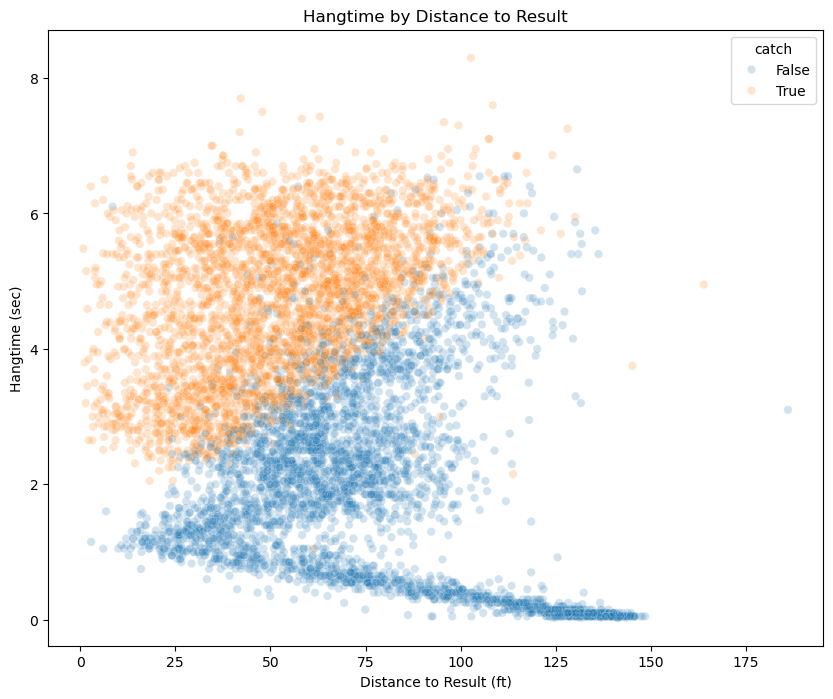

In [19]:
# Plot hangtime by distance to result, hued by batted ball result.
plt.figure(figsize = (10, 8))
sns.scatterplot(data = outfield_play_metrics, x = 'dist_to_result', y ='hangtime', 
                hue = 'catch', alpha = .2)
plt.title('Hangtime by Distance to Result')
plt.xlabel('Distance to Result (ft)')
plt.ylabel('Hangtime (sec)')

This plot is aligning with the finding in Tango's *History of Fielding* in that there are plays that are either automatic hits or outs, and that there exists an opportunity space for fielders to show their skill. Time to explore the data to further understand this opportunity space.

There is a relationship between the distance a fielder needs to travel to get to the ball and the amount of time that they have to get there. However, there are interesting points that occur with hangtimes below 2 seconds. There are a couple of reasons that these points are in the data. The first is that these are batted balls that result inside of the infield and then make their way into the outfield, and therefore have a short hangtime and a high distance to result. These types of batted balls do not allow the outfielder to make a catch and should have the `player_position` attributed to them as either the second baseman or the shortstop.

Intuitively, these balls make sense that they would not be caught as for a player to get to a ball that is 50 feet away from them in under 2 seconds would need the fielder to move at least 25 feet per second which roughly equates to 17mph. That's pretty quick.

Now, to get the number of plays that require a fielder to run at 25 feet per second for each `player_position` and remove as needed. Then check the distribution of route speeds to see if 25 feet per second is a reasonable speed to expect an outfielder in this data to run.

In [20]:
# Get dataframe that requires the outfielder to move 25 feet per second.
speedy = outfield_play_metrics[(outfield_play_metrics['dist_to_result'] >= 50) & 
                               (outfield_play_metrics['hangtime'] <= 2)]

# Look at the number of plays at each position that meet the 25 feet per second requirement.
speedy['player_position'].value_counts()

player_position
6    697
4    535
7     50
9     36
8     12
Name: count, dtype: int64

As expected the majority of these plays are attributed to infielders. This adds more evidence toward these types of plays being those that were hit into the infield and then made their way into the outfield. The plays that are attributed to the infielders will be removed from the plays and the speeds of the remaining plays will be examined.

count    4886.000000
mean       11.769726
std         4.299657
min         0.130000
25%         8.880000
50%        12.255000
75%        15.020000
max        40.790000
Name: direct_route_speed, dtype: float64

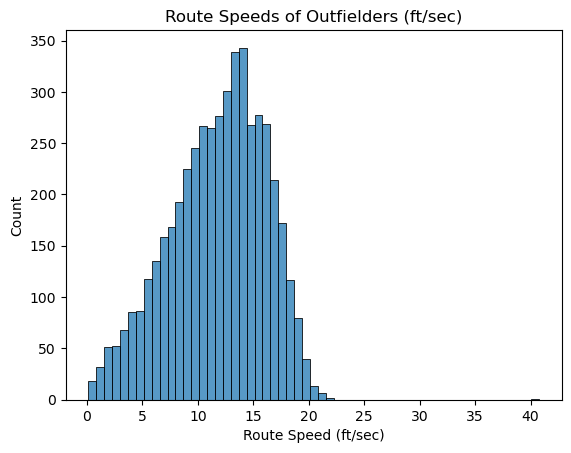

In [21]:
# Remove plays that are attributed to the infielders.
outfield_play_metrics = outfield_play_metrics[~outfield_play_metrics['player_position'].isin([4, 6])]

# Plot the route speeds of outfielders.
plt.figure()
sns.histplot(outfield_play_metrics['direct_route_speed'])
plt.title('Route Speeds of Outfielders (ft/sec)')
plt.xlabel('Route Speed (ft/sec)')

outfield_play_metrics['direct_route_speed'].describe()

Looking at the distribution of `direct_route_speed` of the outfield plays, it appears that there is only a handful of plays that the outfielder would be required to reach a speed of approximately 22 feet per second with the majority of the plays having a `direct_route_speed` of 12 to 15 feet per second.

Let's remove the plays that would require the outfielder to move 25 feet per second or higher as it would be unlikely for the average outfielder to make that catch and then examine the scatterplot again.

C:\Users\scotc\AppData\Local\Temp\ipykernel_15560\3907032268.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outfield_play_metrics['speed_needed'] = outfield_play_metrics['dist_to_result'].div(outfield_play_metrics['hangtime'])


Text(0, 0.5, 'Hangtime (sec)')

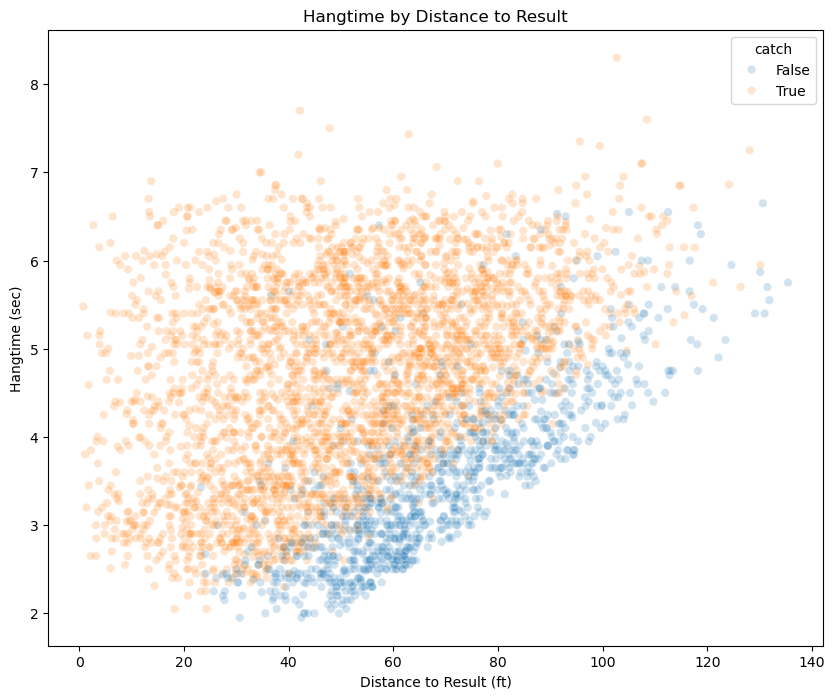

In [22]:
# Create speed needed feature.
outfield_play_metrics['speed_needed'] = outfield_play_metrics['dist_to_result'].div(outfield_play_metrics['hangtime'])

# Remove observations that require more than 25 feet per second.
outfield_play_metrics = outfield_play_metrics[outfield_play_metrics['speed_needed'] <= 25]

# Plot.
plt.figure(figsize = (10, 8))
sns.scatterplot(data = outfield_play_metrics, x = 'dist_to_result', y ='hangtime', hue = 'catch', alpha = .2)
plt.title('Hangtime by Distance to Result')
plt.xlabel('Distance to Result (ft)')
plt.ylabel('Hangtime (sec)')

There still remain plays that were not caught, but these plays won't be filtered out due to the level of play the data is from. These are players from the Minor League, and these plays could potentially be caught by major leaguers. Additionally, if there are outfielders who are able to make the more difficult catches, this could further provide insight into their abilities to perform at the next level.

Now to do a sanity check and ensure that the values within this dataset make sense. Specifically `dist_from_result` which is the distance of the fielder from the ball at the result. These values should be within 5 to 7 feet.

count    3240.000000
mean        2.531947
std         3.432796
min         0.000000
25%         0.862843
50%         1.861227
75%         3.285431
max        97.934505
Name: dist_from_result, dtype: float64

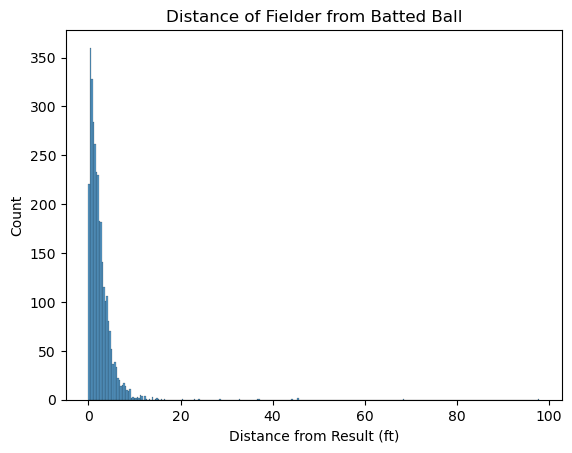

In [23]:
# Filter to balls that were caught.
caught = outfield_play_metrics[outfield_play_metrics['catch'] == True]

# Plot.
sns.histplot(caught['dist_from_result'])
plt.title('Distance of Fielder from Batted Ball')
plt.xlabel('Distance from Result (ft)')

# Loot at descriptive stats.
caught['dist_from_result'].describe()

There are large values that don't quite make sense, especially the values that indicate the outfielder was more than 6 feet away from the ball when caught. This happens during plays where the ball was caught in the infield, then thrown past another infielder into the outfield. An additional factor that can attribute these large values is that not all of the positioning data was recorded for every outfielder for every play. When this was the case the closest outfielder was attributed based on the available data.

To remedy this the observations that have a result of catch and a `dist_from_result` greater than 6 feet will be removed.

Text(0, 0.5, 'Hangtime (sec)')

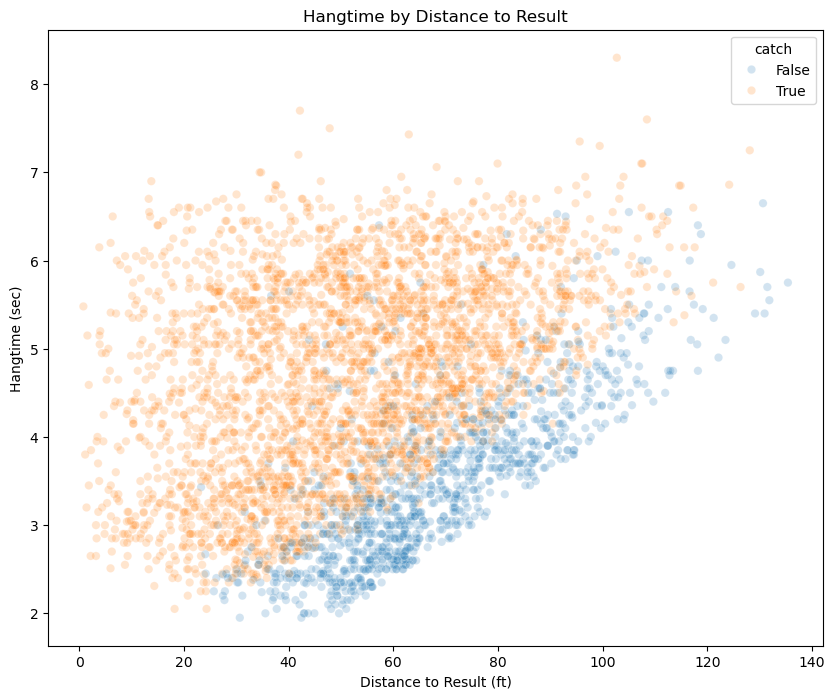

In [24]:
# Get the play keys for plays that are marked as a catch but have the fielder further than 6 feet away.
drop_keys = caught[caught['dist_from_result'] > 6]['play_key']

# Remove plays where distance from result is greater than 6 feet.
outfield_play_metrics = outfield_play_metrics[~outfield_play_metrics['play_key'].isin(drop_keys)]

# Plot.
plt.figure(figsize = (10,8))
sns.scatterplot(data = outfield_play_metrics, x = 'dist_to_result', y ='hangtime', hue = 'catch', alpha = .2)
plt.title('Hangtime by Distance to Result')
plt.xlabel('Distance to Result (ft)')
plt.ylabel('Hangtime (sec)')

Another consideration for whether it is possible to catch the ball is the height of the ball. The data as is will have data points that will contain deflections off of the wall. These can be indicated by the ball not being caught and the result of the batted ball being greater than a resonable height. Let's look at the `ball_position_z` feature and determine a reasonable height to remove observations from the data.

In [25]:
# Query to get the max ball height per catch feature.
query = """
-- Table with the highest ball position grouped by if the ball was caught or not.
SELECT catch,
       MAX(ball_position_z) as highest
FROM outfield_play_metrics
GROUP BY
    catch
"""

wall_balls = queryDB(query)

wall_balls

,catch,highest
0,True,10.42686
1,False,33.20460


Text(0.5, 0, 'Ball Height (ft)')

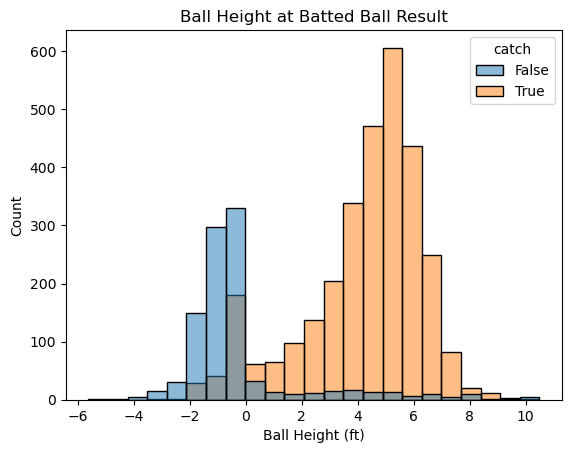

In [26]:
# Keep plays with ball position z less than 10 and a half feet.
outfield_play_metrics = outfield_play_metrics[outfield_play_metrics['ball_position_z'] < 10.5]

# Plot distribution of ball position z.
plt.figure()
sns.histplot(data = outfield_play_metrics, x= 'ball_position_z', hue = 'catch')
plt.title('Ball Height at Batted Ball Result')
plt.xlabel('Ball Height (ft)')

This distribution makes sense with the negative numbers due to the field not being perfectly level. Now to take a final look at the `hangtime` and `dist_to_result` relationship.

Text(0, 0.5, 'Hangtime (sec)')

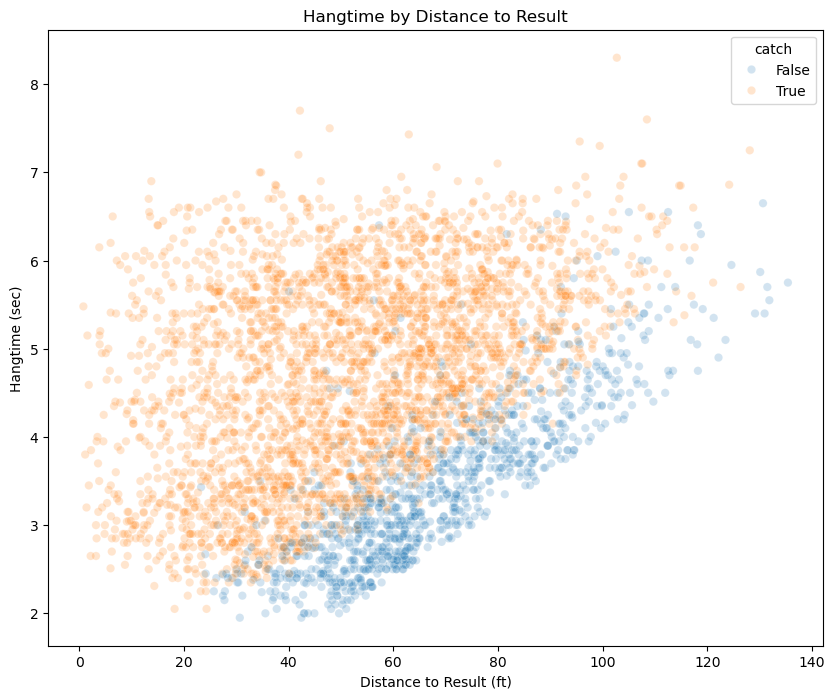

In [27]:
# Plot.
plt.figure(figsize = (10,8))
sns.scatterplot(data = outfield_play_metrics, x = 'dist_to_result', y ='hangtime', hue = 'catch', alpha = .2)
plt.title('Hangtime by Distance to Result')
plt.xlabel('Distance to Result (ft)')
plt.ylabel('Hangtime (sec)')

There are definitely more catches than drops in the data, but for this analysis I want the model to be sure that a catch is truly a catch, or at least should be predicted as such.

Now to attribute the plays to specific outfielders.

## Player Attribution

At this point our metrics table attributes each play to an outfield position. The next step will be to attribute each play in the outfield to its corresponding `player_id`. To do this, a query will be made to the `game_info` table to get the `player_id`s of the outfielders for each play. However, the plays so far have been grouped by the combination of `game_str` and `play_id`. The `game_info` table does not have a `play_id` feature and not every `play_id` has the same value for `play_per_game` that `game_info` uses to identify which players are on the field. To navigate this, a new table will be created that will get the corresonding `play_per_game` for each `play_id`. Then using the table that maps the `play_key` to the `play_per_game` the corresponding outfielders will be determined.

In [28]:
# Query to map play keys to plays per game, then attribute outfielders to play.
query = """
-- CTE Table with trimmed play keys to corresponding game string and play per game.
WITH key_to_ppg AS (SELECT DISTINCT opm.play_key,
                           ge.game_str,
                           ge.play_per_game
                    FROM outfield_play_metrics AS opm
                    JOIN (SELECT game_str || '_' || play_id AS play_key,
                                 game_str,
                                 play_per_game
                          FROM game_events) AS ge
                    ON opm.play_key = ge.play_key),
-- CTE Table with the play key and player ids for the outfielders.
key_to_positions AS (SELECT DISTINCT kppg.play_key,
                            gi.left_field,
                            gi.center_field,
                            gi.right_field
                     FROM key_to_ppg AS kppg
                     JOIN game_info AS gi
                     ON kppg.game_str = gi.game_str 
                        AND kppg.play_per_game = gi.play_per_game)
-- Table with outfielders attributed where found.
SELECT opm.*,
       CASE opm.player_position
            WHEN 7 THEN ktp.left_field
            WHEN 8 THEN ktp.center_field
            WHEN 9 THEN ktp.right_field
            ELSE NULL
       END AS player_id
FROM outfield_play_metrics AS opm
LEFT JOIN key_to_positions AS ktp
ON opm.play_key = ktp.play_key
"""

outfield_play_metrics = queryDB(query)

outfield_play_metrics

,play_key,player_position,hangtime,direct_dist_traveled,direct_route_speed,dist_to_result,dist_from_result,ball_position_z,angle_route,catch,speed_needed,player_id
0,y1_d099_MRJ_YJD_186,8,3.65,59.705741,16.36,80.695571,23.324922,-0.691536,25.469719,False,22.108376,YJD-0193
1,y2_d007_NSO_YJD_59,9,4.10,32.990463,8.05,32.983772,0.071703,7.432320,-21.197090,True,8.044823,NSO-2240
2,y1_d040_TKJ_YJD_67,8,6.25,69.130160,11.06,68.868289,0.375755,4.619580,50.571809,True,11.018926,TKJ-2441
3,y1_d073_UWE_YJD_202,9,2.60,36.873093,14.18,60.873959,36.452778,-1.176324,-12.214310,False,23.413061,UWE-1876
4,y2_d026_VMN_YJD_103,8,6.35,71.955861,11.33,71.395404,1.147388,6.559740,-152.157371,True,11.243371,VMN-1279
...,...,...,...,...,...,...,...,...,...,...,...,...
4028,y1_d025_JIL_RZQ_150,8,4.25,74.956011,17.64,73.433899,2.129781,0.321354,-81.363101,True,17.278564,None
4029,y1_d031_REC_QEA_21,8,3.30,47.187779,14.30,51.141598,3.954114,0.312366,-58.162810,True,15.497454,None
4030,y1_d033_REC_QEA_53,7,3.35,46.803670,13.97,60.496832,15.867162,-1.427928,-118.193875,False,18.058756,None
4031,y1_d033_REC_QEA_187,9,3.85,48.782877,12.67,45.088309,4.372381,6.136050,93.193961,True,11.711249,None


Uh oh, looks like the data has picked up additional observations, and not every play is being attributed to a player.

Let's deal with the duplicates first by taking a look at the counts for `play_keys` and see where we have duplicates.

In [29]:
# Query to get the duplicate play keys after attribution.
query = """
-- CTE with duplicate play keys.
WITH duplicates AS (SELECT play_key,
                           COUNT(*) AS n
                    FROM outfield_play_metrics
                    GROUP BY play_key
                    HAVING n > 1)
SELECT opm.play_key,
       opm.player_id
FROM outfield_play_metrics AS opm
JOIN duplicates AS d
ON opm.play_key = d.play_key
"""

# Returns duplicate play keys.
duplicates = queryDB(query)

duplicates

,play_key,player_id
0,y2_d045_IHI_YJD_6,IHI-2444
1,y2_d007_NSO_YJD_16,NSO-1891
2,y2_d022_DMS_RZQ_10,DMS-1813
3,y2_d045_IHI_YJD_6,YJD-0345
4,y2_d007_NSO_YJD_16,YJD-0106
5,y2_d022_DMS_RZQ_10,RZQ-0409


Looking at these observations, it appears that there are two different outfielders being attributed to the same play. This leads me to believe that there is an issue with the `play_per_game` feature inside of the `game_info` table for these respective games.

In [30]:
# Query to get game info for duplicate plays.
query = """
-- CTE Table with trimmed play keys to corresponding game string and play per game.
WITH key_to_ppg AS (SELECT DISTINCT opm.play_key,
                           ge.game_str,
                           ge.play_per_game
                    FROM outfield_play_metrics AS opm
                    JOIN (SELECT game_str || '_' || play_id AS play_key,
                                 game_str,
                                 play_per_game
                          FROM game_events) AS ge
                    ON opm.play_key = ge.play_key)
-- Table with the game information for plays that had duplicates.
SELECT gi.*
FROM game_info as gi
JOIN key_to_ppg AS ktp
ON gi.game_str = ktp.game_str 
   AND gi.play_per_game = ktp.play_per_game
WHERE ktp.play_key IN (SELECT play_key
                       FROM duplicates)

"""

# Returns game information of duplicate plays.
duplicates_gi = queryDB(query)

duplicates_gi

,game_str,home_team,away_team,at_bat,play_per_game,top_bottom_inning,pitcher,catcher,first_base,second_base,...,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,year,day
0,y2_d045_IHI_YJD,YJD,IHI,4.0,6.0,top,YJD-0141,YJD-0007,YJD-0366,YJD-0304,...,YJD-0312,YJD-0327,YJD-0345,YJD-0340,IHI-2289,NA,NA,NA,year_2,day_045
1,y2_d045_IHI_YJD,YJD,IHI,4.0,6.0,bottom,IHI-2286,IHI-1314,IHI-1642,IHI-1907,...,IHI-2289,IHI-2576,IHI-2444,IHI-1223,YJD-0327,NA,NA,NA,year_2,day_045
2,y2_d022_DMS_RZQ,RZQ,DMS,6.0,10.0,bottom,DMS-1950,DMS-2426,DMS-1249,DMS-1108,...,DMS-1242,DMS-1813,DMS-1575,DMS-2214,RZQ-0347,NA,NA,NA,year_2,day_022
3,y2_d022_DMS_RZQ,RZQ,DMS,6.0,10.0,top,RZQ-0324,RZQ-0006,RZQ-0333,RZQ-0347,...,RZQ-0355,RZQ-0409,RZQ-0310,RZQ-0231,DMS-2426,DMS-2354,NA,NA,year_2,day_022
4,y2_d007_NSO_YJD,YJD,NSO,5.0,16.0,top,YJD-0420,YJD-0024,YJD-0373,YJD-0278,...,YJD-0312,YJD-0397,YJD-0106,YJD-0366,NSO-1990,NSO-1360,NA,NA,year_2,day_007
5,y2_d007_NSO_YJD,YJD,NSO,5.0,16.0,bottom,NSO-2231,NSO-2061,NSO-1990,NSO-1232,...,NSO-1360,NSO-1437,NSO-1891,NSO-2240,YJD-0229,NA,NA,NA,year_2,day_007


As suspected there are multiple respresentations in the `play_per_game` feature for these `game_str`s.

After examining the sections of the data that contain the duplicates, it appears that the duplicates come near the end of a half inning, switching from the top to the bottom. To determine the correct outfielder to attribute the play to, the play before the duplicate will be examined and the inning of that play will be used to select the outfielder to be attributed. Then the correct attribution will be applied to metrics table, at the end there should be 4,030 observations.

In [31]:
# Query to get the data from the game info table for the games that have duplicates.
query = """
SELECT gi.*
FROM game_info as gi
WHERE gi.game_str IN (SELECT game_str
                      FROM duplicates_gi)
"""

# Returns duplicate game info.
all_duplicate_gi = queryDB(query)

# Initialize dictionary to hold duplicate information.
duplicate_dict = {'y2_d022_DMS_RZQ': 10,
                  'y2_d007_NSO_YJD': 16,
                  'y2_d045_IHI_YJD': 6}

# Initialize accumulator for rows.
prev_rows = []

# For loop to iterate over the game_str in dictionary.
for game, play in duplicate_dict.items():

    # Get indexes of the duplicate play_per_game.
    play_indexes = all_duplicate_gi[(all_duplicate_gi['game_str'] == game) & 
                                    (all_duplicate_gi['play_per_game'] == play)].index

    # Get the row of the previous play.
    prev = all_duplicate_gi.loc[[play_indexes[0] - 1]]

    # Create play_key and extract the team.
    prev['play_key'] = game + '_' + str(play)
    prev['team'] = prev['center_field'].str.split('-').str[0]
    prev = prev[['play_key', 'team']]
    
    # Add to accumulator.
    prev_rows.append(prev)
    
# Concat into single dataframe.
corrected_attribution = pd.concat(prev_rows)

corrected_attribution

,play_key,team
7,y2_d022_DMS_RZQ_10,RZQ
549,y2_d007_NSO_YJD_16,YJD
240,y2_d045_IHI_YJD_6,YJD


Now that the correct attribution can be made, a new feature of `player_team` will be made in the metrics table. This will be used to correct the attribution, and will be a useful feature for later.

Additionally, the missing `player_id`s that were unable to be attributed due to gaps in the `game_info` table will be given placeholder values. These placeholder values will be a new `player_id` that is a combination of the venue where the game is being played and the position of the player. For example, a missing `player_id` for the center fielder at YJD would have a new `player_id` of YJD-8888.

In [32]:
# Query fixing duplicate attribution, and assigning placeholder player ids.
query = """
-- CTE creating venue feature.
WITH venues AS (SELECT play_key,
                       STRING_SPLIT(play_key, '_')[4] AS venue
                       FROM outfield_play_metrics),
-- CTE to attribute missing player ids.
player_ids AS (SELECT opm.play_key,
                      v.venue,
                      -- Assign missing player id.
                      CASE
                          WHEN player_id IS NULL and player_position = 7 THEN v.venue || '-7777'
                          WHEN player_id IS NULL and player_position = 8 THEN v.venue || '-8888'
                          WHEN player_id IS NULL and player_position = 9 THEN v.venue || '-9999'
                          ELSE player_id
                      END AS updated_id
                FROM outfield_play_metrics AS opm
                JOIN venues AS v
                ON opm.play_key = v.play_key),
-- Table that has corrected player ids, add venue, and play metrics.
metrics AS (SELECT DISTINCT opm.play_key,
                   pi.venue,
                   LEFT(pi.updated_id, 3) AS player_team,
                   pi.updated_id AS player_id,
                   opm.player_position,
                   opm.hangtime,
                   opm.direct_dist_traveled,
                   opm.direct_route_speed,
                   opm.dist_to_result,
                   opm.dist_from_result,
                   opm.ball_position_z,
                   opm.angle_route,
                   opm.catch
FROM outfield_play_metrics AS opm
JOIN player_ids AS pi
ON opm.play_key = pi.play_key)
-- Table with metrics that filters out the incorrectly attributed plays.
SELECT m.*
FROM metrics AS m
LEFT JOIN corrected_attribution AS ca
ON m.play_key = ca.play_key
WHERE ca.team IS NULL 
      OR m.player_team = ca.team
"""

# Returns metrics table with removed duplicates and added place holders.
outfield_play_metrics = queryDB(query)

outfield_play_metrics

,play_key,venue,player_team,player_id,player_position,hangtime,direct_dist_traveled,direct_route_speed,dist_to_result,dist_from_result,ball_position_z,angle_route,catch
0,y1_d050_UPU_YJD_249,YJD,YJD,YJD-0017,8,4.45,79.440919,17.85,79.067370,1.149635,5.838810,137.098219,True
1,y2_d068_RDO_RZQ_57,RZQ,RDO,RDO-2171,8,4.00,52.079590,13.02,48.515113,4.058402,6.897270,88.715348,True
2,y1_d071_ACN_QEA_138,QEA,ACN,ACN-1147,8,3.45,17.242553,5.00,19.509286,2.336055,4.083600,-115.258692,True
3,y2_d064_ESW_YJD_16,YJD,ESW,ESW-2445,7,3.25,16.811300,5.17,15.347382,1.481910,3.094380,-14.992998,True
4,y1_d067_IAQ_YJD_86,YJD,YJD,YJD-0193,8,5.94,58.572062,9.86,58.336827,0.564538,6.539670,-19.326525,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4025,y1_d045_VHS_YJD_179,YJD,YJD,YJD-8888,8,5.80,34.025367,5.87,33.403678,0.665115,5.431290,45.357214,True
4026,y1_d032_REC_QEA_114,QEA,QEA,QEA-9999,9,2.74,40.913570,14.94,44.539176,9.689372,-0.393852,-28.336523,False
4027,y2_d005_DYE_RZQ_116,RZQ,RZQ,RZQ-8888,8,5.10,72.252850,14.17,71.961825,1.559408,5.382810,30.290394,True
4028,y1_d094_WNA_RZQ_51,RZQ,RZQ,RZQ-8888,8,5.45,70.664655,12.97,68.413032,2.278122,3.755370,-57.204267,True


Great! Now that the data has been validated,features for analysis can be engineered.

## Feature Engineering

### Top Route Speed and Total Distance

So far the only speed metric attributed to the play is the simple overall speed of how far the fielder traveled by how long the ball was in the air. Now to get the top speed during the route.

To do this, the marginal positions from one timestamp to the next will be extracted. From there the distance between timestamps can be calculated. The frames per second for each play is known, so the distance over time can be used to calculate the speed. The time stamps are in milliseconds, and the final speed metric should be in feet per second. 

$20 fps: Speed = \frac{distance}{.05}$

$33 fps: Speed = \frac{distance}{.33}$

With the speed known at every timestamp, a rolling average can be done on the speed values. The window for the rolling average will be 1 second (50ms = 20 timestamps, 33ms = 29 timestamps) from which the max speed will be taken for the max speed of the play. This window and method was determined after reviewing Statcast's criteria for [sprint speed](https://baseballsavant.mlb.com/leaderboard/sprint_speed).

Additionally, since the distance between timestamps is known, the accumulative distance traveled can be calculated by summing all of the marginal distances.

This will produce a dataframe that has the marginal metrics between timestamps. So the position (`field_x`, `field_y`), marginal distance in feet, marginal speed in feet per second, rolling average of speed per 1 second window in feet per second, and the accumulative distance traveled in feet.

In [33]:
outfield_play_details

,play_key,player_position,timestamp_pitch,timestamp_hit,timestamp_result,msf,hangtime,catch
0,y1_d001_CGA_QEA_108,8,4090155,4090605,4094005,50,3400,False
1,y1_d001_CGA_QEA_114,9,4226105,4226605,4231155,50,4550,True
2,y1_d001_CGA_QEA_127,8,4819205,4819705,4824205,50,4500,True
3,y1_d001_CGA_QEA_128,7,4856155,4856555,4858655,50,2100,False
4,y1_d001_CGA_QEA_130,9,4913255,4913705,4916755,50,3050,True
...,...,...,...,...,...,...,...,...
6896,y2_d099_YJD_RZQ_69,8,2201848,2202248,2206748,50,4500,True
6897,y2_d099_YJD_RZQ_7,9,175498,175898,178648,50,2750,False
6898,y2_d099_YJD_RZQ_81,7,2655248,2655648,2661048,50,5400,True
6899,y2_d099_YJD_RZQ_95,7,3094748,3095198,3095298,50,100,False


In [34]:
# Query to get the marginal speeds and distances, calculated rolling average for speed, and accumulative distance traveled.
query = """
-- CTE to get the timestamps attributed to play.
WITH key_to_ts AS (SELECT opd.play_key,
                          opm.player_position,
                          opm.player_id,
                          opd.timestamp_pitch,
                          opd.timestamp_result,
                          opd.msf
              FROM outfield_play_details AS opd
              JOIN outfield_play_metrics AS opm
              ON opd.play_key = opm.play_key),
-- CTE with player player position data from pitch to result with msf.
player_position_per_route AS (SELECT pp.game_str || '_' || CAST(pp.play_id AS INT) AS play_key,
                                     pp.player_position,
                                     ktt.player_id,
                                     ktt.msf,
                                     pp.timestamp,
                                     pp.field_x,
                                     pp.field_y
                              FROM player_pos AS pp
                              JOIN key_to_ts AS ktt
                              ON pp.game_str || '_' || CAST(pp.play_id AS INT)= ktt.play_key
                                 AND pp.player_position = ktt.player_position
                                 AND pp.timestamp BETWEEN ktt.timestamp_pitch AND ktt.timestamp_result),
-- CTE with marginal distances, contains NULLS at first position.
marg_positions AS (SELECT play_key,
                          player_id,
                          timestamp,
                          msf,
                          field_x,
                          field_y,
                          LAG(field_x) OVER (PARTITION BY play_key
                                             ORDER BY timestamp) AS marg_x,
                          LAG(field_y) OVER (PARTITION BY play_key
                                             ORDER BY timestamp) AS marg_y
                  FROM player_position_per_route),
-- CTE with marginal metrics speeds.
marg_metrics AS (SELECT play_key,
                        player_id,
                        msf,
                        timestamp,
                        SQRT(POWER(field_x - marg_x, 2) + POWER(field_y - marg_y, 2)) AS marg_dist,
                        -- Distance between points divided by .05 or .033 seconds (50 ms/33ms).
                        CASE
                            WHEN msf = 50 THEN SQRT(POWER(field_x - marg_x, 2) + POWER(field_y - marg_y, 2)) / .05 
                            ELSE SQRT(POWER(field_x - marg_x, 2) + POWER(field_y - marg_y, 2)) / .033 
                        END AS speed_ft_sec
                FROM marg_positions
                WHERE marg_x IS NOT NULL
                      AND marg_y IS NOT NULL)
-- Table with rolling average for speed in ft/sec during 1 second window (50ms = 20 frames, 33ms = 29), as well as accumulative dist traveled.
SELECT mm.play_key,
       mm.player_id,
       CAST(mm.timestamp AS INT) AS timestamp,
       mm.msf,
       mp.field_x,
       mp.field_y,
       mm.speed_ft_sec,
       -- Set rolling average window for each msf.
       CASE
       WHEN mm.msf = 50 THEN AVG(mm.speed_ft_sec) OVER (PARTITION BY mm.play_key
                                                  ORDER BY mm.timestamp
                                                  ROWS BETWEEN 19 PRECEDING AND CURRENT ROW)
       ELSE AVG(mm.speed_ft_sec) OVER (PARTITION BY mm.play_key
                                       ORDER BY mm.timestamp
                                       ROWS BETWEEN 29 PRECEDING AND CURRENT ROW)
       END AS rolling_avg_ft_sec,
       mm.marg_dist,
       -- Get accumulative distance.
       SUM(mm.marg_dist) OVER (PARTITION BY mm.play_key
                               ORDER BY mm.timestamp) AS acc_dist,
       -- Add indexes for easier analysis.
       ROW_NUMBER() OVER (PARTITION BY mm.play_key
                          ORDER BY mm.timestamp) AS n
FROM marg_metrics AS mm
JOIN marg_positions AS mp
ON mm.play_key = mp.play_key
   AND mm.timestamp = mp.timestamp
"""
# Returns table with marginal metrics for each play.
marg_metrics_play = queryDB(query)

marg_metrics_play

,play_key,player_id,timestamp,msf,field_x,field_y,speed_ft_sec,rolling_avg_ft_sec,marg_dist,acc_dist,n
0,y1_d002_CGA_QEA_159,QEA-0365,5714171,50,-135.3675,255.0723,0.296985,0.296985,0.014849,0.014849,1
1,y1_d002_CGA_QEA_159,QEA-0365,5714221,50,-135.3651,255.0870,0.297893,0.297439,0.014895,0.029744,2
2,y1_d002_CGA_QEA_159,QEA-0365,5714271,50,-135.3627,255.1017,0.297893,0.297590,0.014895,0.044639,3
3,y1_d002_CGA_QEA_159,QEA-0365,5714321,50,-135.3603,255.1164,0.297893,0.297666,0.014895,0.059533,4
4,y1_d002_CGA_QEA_159,QEA-0365,5714371,50,-135.3579,255.1311,0.297893,0.297711,0.014895,0.074428,5
...,...,...,...,...,...,...,...,...,...,...,...
418610,y2_d096_QZE_RZQ_56,RZQ-0409,37440,33,-95.1612,354.4371,23.536506,28.114454,0.776705,96.359259,162
418611,y2_d096_QZE_RZQ_56,RZQ-0409,37473,33,-95.6598,353.8455,23.445079,28.096978,0.773688,97.132947,163
418612,y2_d096_QZE_RZQ_56,RZQ-0409,37506,33,-96.1212,353.2497,22.835452,28.032070,0.753570,97.886517,164
418613,y2_d096_QZE_RZQ_56,RZQ-0409,37539,33,-96.5790,352.6176,23.650564,28.014169,0.780469,98.666985,165


Now that the marginal metrics of each route are known, the route can be broken into distinct phases. Statcast's [Jump](https://baseballsavant.mlb.com/leaderboard/outfield_jump) refers to the first 3 seconds of a route, which is broken up into two phases:

**Reaction:** 0 - 1.5 seconds (20 fps: 0 - 30 timestamps, 33 fps: 0 - 45 timestamps)

**Burst:** 1.6 - 3 seconds (20 fps: 31 - 60 timestamps, 33 fps: 46 - 90 timestamps)

However, burst is only tracked for plays that are rated as two stars or above. This is based on the probability of the catch, which won't be know until the model is created. So for now, the focus will be on the reaction of the outfielder and the duration of the whole route.

From the burst phase and the duration of the route, the total distance traveled and the max rolling average in a 1 second window for the speed will be extracted.

This results in a dataframe containing the max sprint speed of the burst phase in feet per second, total distance traveled in the react phase in feet, the max sprint speed of the entire route in feet per second, and the total distance the fielder traveled over the route in feet.

In [35]:
# Query to get the distance traveled in the first 1.5 seconds, the max sprint speed, and total accumulative distance traveled during the route.
query = """
-- CTE with aggregated react metrics for 20 fps.
WITH react_dist_speed_20 AS (SELECT play_key,
                                    player_id,
                                    MAX(acc_dist) AS t_dist_react,
                              -- Table with metrics for 20 fps in react range.
                              FROM (SELECT *
                                    FROM marg_metrics_play
                                    WHERE msf = 50) AS n_20
                              WHERE n BETWEEN 1 AND 30
                              GROUP BY play_key,
                                       player_id),
-- CTE with aggregated react metrics for 33 fps.
react_dist_speed_33 AS (SELECT play_key,
                               player_id,
                               MAX(acc_dist) AS t_dist_react,
                        -- Table with metrics for 33 fps in react range.
                        FROM (SELECT *
                              FROM marg_metrics_play
                              WHERE msf = 33) AS n_33
                        WHERE n BETWEEN 1 AND 45
                        GROUP BY play_key,
                                 player_id),
-- CTE with combined react aggregated metrics.
react_dist_speed_all AS (SELECT *
                         FROM react_dist_speed_33
                         UNION
                         SELECT *
                         FROM react_dist_speed_20),
-- CTE with max rolling average sprint speed during route.
max_route AS (SELECT play_key,
                      MAX(rolling_avg_ft_sec) AS max_sprint,
                      MAX(acc_dist) AS t_route_dist
               FROM  marg_metrics_play
               GROUP BY play_key)
-- Table with max speed and distance for react phase, as well as total route distance and max 1 sec window sprint speed.
SELECT rds.play_key,
       rds.player_id,
       rds.t_dist_react,
       mr.max_sprint,
       mr.t_route_dist
FROM react_dist_speed_all AS rds
JOIN max_route AS mr
ON rds.play_key = mr.play_key
"""

# Returns react distance, total accumulative distance and the max sprint speed of each route.
player_route = queryDB(query)

player_route

,play_key,player_id,t_dist_react,max_sprint,t_route_dist
0,y1_d007_MCJ_RZQ_72,RZQ-8888,6.597260,15.370473,26.028537
1,y1_d009_DYE_RZQ_165,RZQ-9999,2.572106,15.043913,56.003298
2,y1_d009_DYE_RZQ_299,DYE-0238,1.796318,10.675704,46.228552
3,y1_d016_OXG_QEA_295,OXG-0018,5.679290,22.531473,69.924870
4,y1_d024_AKX_YJD_156,AKX-2076,5.300967,24.422652,86.591211
...,...,...,...,...,...
4025,y2_d074.5_VZE_YJD_68,VZE-1946,3.345006,11.755830,32.815014
4026,y2_d076_MGJ_RZQ_2,RZQ-0275,4.356394,29.529471,70.290253
4027,y2_d079_YJD_RZQ_82,RZQ-0279,2.612829,3.224020,10.709397
4028,y2_d083.5_WMI_YJD_62,YJD-0345,5.168544,26.060457,119.723732


Now to validate these new metrics.

#### Speed and Distance Validation

Start out by checking the distributions of each metric to ensure the values pass the eye test.

Text(0.5, 0, 'Max Speed (ft/sec)')

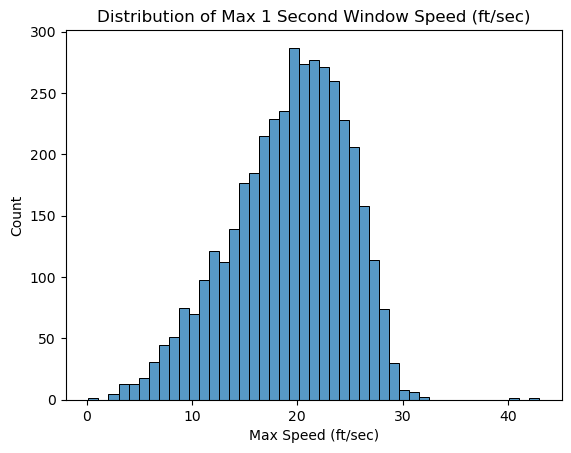

In [36]:
sns.histplot(player_route['max_sprint'])
plt.title('Distribution of Max 1 Second Window Speed (ft/sec)')
plt.xlabel('Max Speed (ft/sec)')

The distribution is approximately normal, with a few values that are rather far from the majority of values. Having a max sprint speed of 40 feet per second is also quite quick. Let's investigate these further.

In [37]:
# Filter dataframe to outliers.
fast_routes = player_route[player_route['max_sprint'] > 35]

# Filter to fast routes
fast_plays = outfield_play_metrics[outfield_play_metrics['play_key'].isin(fast_routes['play_key'])]

fast_plays

,play_key,venue,player_team,player_id,player_position,hangtime,direct_dist_traveled,direct_route_speed,dist_to_result,dist_from_result,ball_position_z,angle_route,catch
979,y1_d042_TKJ_YJD_208,YJD,YJD,YJD-7777,7,4.75,47.144449,9.93,46.704738,0.777515,5.528400,-146.518748,True
2359,y1_d095_KQQ_YJD_180,YJD,KQQ,KQQ-1320,7,2.50,23.054589,9.22,30.113099,11.552859,-0.591522,-3.353983,False


Looks like there could be a gap in the player positioning data for YJD-7777. Let's look at the marginal metrics to see if the fielder has any large marginal changes in speed.

In [38]:
# Query to get the marginal distance for YJD-7777 route.
query = """
SELECT *
FROM marg_metrics_play
WHERE play_key = 'y1_d042_TKJ_YJD_208'
ORDER BY marg_dist DESC
LIMIT 1
"""

# Returns the largest change in marginal distance
fast_marg = queryDB(query)

fast_marg

,play_key,player_id,timestamp,msf,field_x,field_y,speed_ft_sec,rolling_avg_ft_sec,marg_dist,acc_dist,n
0,y1_d042_TKJ_YJD_208,YJD-7777,6449149,50,-159.1821,211.1769,527.208093,34.132214,26.360405,34.812993,43


**y1_d095_KQQ_YJD_180**

Looking at the metrics for the play, the batted ball appears to be a line drive near the outfielder that was not caught. Which looking at the distance needed to cover to get to the result (~27 feet) and comparing it to the recorded max speed, the fielder should have caught the ball. For this observation the route metrics will be imputed with the fielders mean values.

**y1_d042_TKJ_YJD_208**

The metrics for the react phase look plausible, however, the rest of the route metrics look suspect when compared to the metrics of the play. The hangtime is above 4 seconds, which would indicate a pop-up and the fielder was about 50 feet away from the result. It seems implausible that the fielder would have moved upwards of 40 feet per second in this time period. Examining the marginal distances, which in this case are 50ms apart, there is a 50ms time frame where the position data indicates that the fielder moved around 26 feet. This is unlikely. Additionally, this observation is one that a `player_id` was not able to be determined through the `game_info` table. Due to the inconsistencies inside the positioning data on this play and the fact that the play cannot be attributed to a specific player, this play will be removed from the dataset.

In [39]:
# Remove play from dataset.
outfield_play_metrics = outfield_play_metrics[outfield_play_metrics['play_key'] != 'y1_d042_TKJ_YJD_208'] 
marg_metrics_play = marg_metrics_play[marg_metrics_play['play_key'] != 'y1_d042_TKJ_YJD_208'] 
player_route = player_route[player_route['play_key'] != 'y1_d042_TKJ_YJD_208']

# Dataframe with average metrics of KQQ-1320 without questionable play.
query = """
SELECT player_id,
       AVG(t_dist_react) AS t_dist_react,
       AVG(max_sprint) AS max_sprint,
       AVG(t_route_dist) AS t_route_dist
FROM player_route
WHERE player_id = 'KQQ-1320'
      AND play_key <> 'y1_d095_KQQ_YJD_180'
GROUP BY player_id
"""
# Run query.
avg_metrics = queryDB(query)

# Feats to imputes.
feats_impute = ['t_dist_react', 'max_sprint', 't_route_dist']

# Impute values.
player_route.loc[player_route['play_key'] =='y1_d095_KQQ_YJD_180', feats_impute] = avg_metrics[feats_impute].values

Text(0.5, 0, 'Max Speed (ft/sec)')

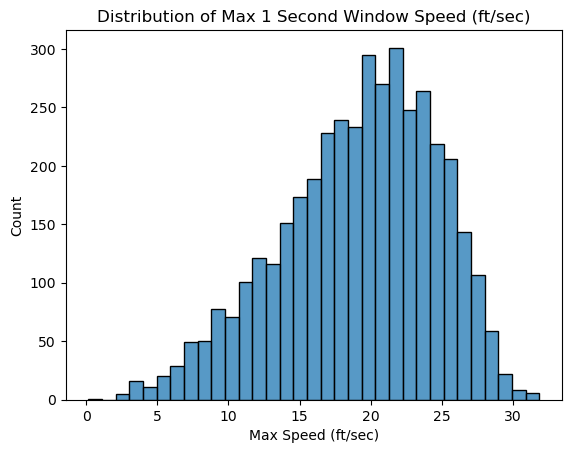

In [40]:
sns.histplot(player_route['max_sprint'])
plt.title('Distribution of Max 1 Second Window Speed (ft/sec)')
plt.xlabel('Max Speed (ft/sec)')

This looks better. Now to look at distance traveled in the first 1.5 seconds of the route.

Text(0.5, 0, 'React Distance (ft)')

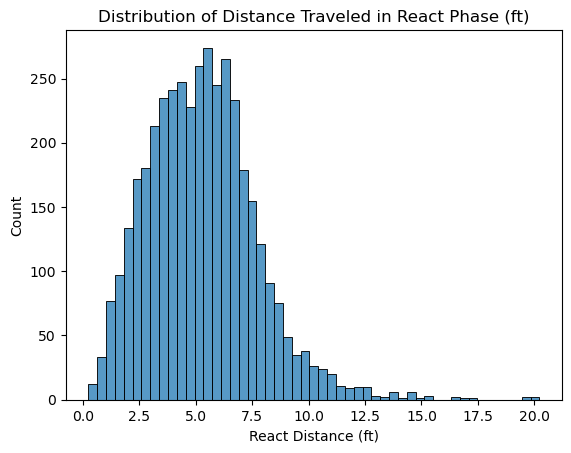

In [41]:
sns.histplot(player_route['t_dist_react'])
plt.title('Distribution of Distance Traveled in React Phase (ft)')
plt.xlabel('React Distance (ft)')

The distribution looks slightly skewed, with only a handful of values that fall outside the a majority of the distribution. Let's check the individual route metrics to see if these values seem plausible.

In [42]:
# Filter dataframe to distances over 16 feet.
player_route[player_route['t_dist_react'] > 16]

,play_key,player_id,t_dist_react,max_sprint,t_route_dist
191,y1_d049_UPU_YJD_216,UPU-1731,17.417999,24.859672,78.383946
539,y1_d046_MHY_RZQ_194,MHY-1227,20.222928,19.186164,47.361745
901,y1_d039_HMN_RZQ_150,HMN-1212,16.626038,23.922629,72.707939
1503,y2_d068_RDO_RZQ_227,RDO-2171,16.506837,20.611550,85.498166
2223,y1_d009_DYE_RZQ_8,RZQ-7777,19.646208,23.298137,80.721474
2226,y1_d021_JFU_YJD_209,JFU-2129,16.860708,26.027940,85.348764
2459,y1_d096_KQQ_YJD_88,KQQ-1402,19.569422,25.650835,90.055105
3459,y1_d036_HMN_RZQ_32,HMN-1226,19.941435,27.269159,107.594861


The distribution for `t_react_dist`, which is the total distance that the fielder covered in the first 1.5 seconds of the route, has some values that seem high with some routes having a fielder move more than 15 feet. While being on the high end of the distribution, this does not seem implausible given the fact there are speeds that could realistically be near 20 feet over 1 second. Bringing in the other route metrics for context, these values seem to align and no observations will be trimmed.

Text(0.5, 0, 'Distance Traveled (ft)')

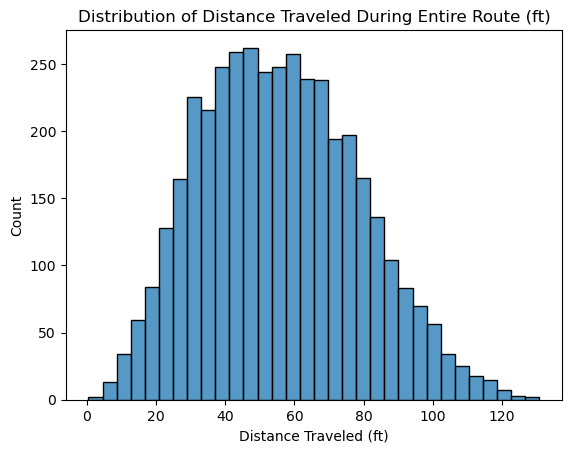

In [43]:
sns.histplot(player_route['t_route_dist'])
plt.title('Distribution of Distance Traveled During Entire Route (ft)')
plt.xlabel('Distance Traveled (ft)')

Phew, this one looks great!

Now that the metrics have been validated, it is time to get the aggregate metrics for each player. The simple mean will be taken for each of these metrics, as well as the average for the top third. The thinking behind taking the mean of the top third of metrics is to eliminate non-competitive plays and focusing on when the fielder needs to perform at a high level. The top third max sprint speed will be used to create a route intensity feature.

### Aggregated Speed and Distance Metrics

In [44]:
# Query to get the aggregated metrics for mean distances, and sprint speeds.
query = """
-- CTE getting average metrics for each player over all routes.
WITH avg_all AS (SELECT player_id,
                        COUNT(*) AS n_routes,
                        AVG(t_dist_react) AS mean_dist_react,
                        AVG(max_sprint) AS mean_max_sprint,
                        MAX(max_sprint) AS max_sprint,
                        AVG(t_route_dist) AS mean_route_dist,
                        SUM(t_route_dist) AS acc_dist
                 FROM player_route
                 GROUP BY player_id),
-- CTE getting value of the top 3rd of metrics for each player over all routes.                     
p66_values AS (SELECT play_key,
                      player_id,
                      QUANTILE_CONT(max_sprint, .66) OVER (PARTITION BY player_id) AS p66_max_sprint,
               FROM player_route),                   
-- CTE for top 3rd max sprint.
max_sprint_66 AS (SELECT pr.player_id,
                         AVG(pv.p66_max_sprint) AS p66_max_sprint,
                  FROM player_route AS pr
                  JOIN p66_values AS pv
                  ON pr.play_key = pv.play_key
                     AND pr.player_id = pv.player_id
                  WHERE pr.max_sprint >= pv.p66_max_sprint
                  GROUP BY pr.player_id)
-- Table with average metrics for all routes and average metrics for top 3rd of routes.
SELECT aa.player_id,
       aa.n_routes,
       aa.mean_dist_react,
       aa.mean_max_sprint,
       aa.max_sprint,
       aa.mean_route_dist,
       aa.acc_dist,
       ms66.p66_max_sprint,
FROM avg_all AS aa
JOIN max_sprint_66 AS ms66 ON aa.player_id = ms66.player_id
"""

# Returns table with aggregate distance and speed metrics.
player_mean_route_metrics = queryDB(query)

player_mean_route_metrics

,player_id,n_routes,mean_dist_react,mean_max_sprint,max_sprint,mean_route_dist,acc_dist,p66_max_sprint
0,RZQ-0014,42,5.085143,18.547517,29.185707,49.986079,2099.415319,22.133386
1,QEA-0235,49,5.181266,19.699849,28.667353,59.504428,2915.716963,22.852188
2,JJS-2128,10,5.652171,20.895711,27.491032,65.823405,658.234051,22.052550
3,RQJ-2500,9,5.318639,19.574273,28.755310,55.829286,502.463573,21.843414
4,ESW-2213,4,6.198774,24.102156,26.409915,76.027909,304.111638,25.722849
...,...,...,...,...,...,...,...,...
379,DYE-0188,2,4.080345,19.564291,26.669692,54.222622,108.445245,21.838019
380,JNJ-1930,1,3.781016,7.631213,7.631213,31.008903,31.008903,7.631213
381,UWE-1286,1,6.105497,20.981541,20.981541,61.208123,61.208123,20.981541
382,YJD-0224,1,4.827624,23.957690,23.957690,57.451988,57.451988,23.957690


### Intensity

Now that the average top third speed has been calculated, this can be compared to a player's speed during the route and determine the level of effort exerted in that specific window. This will be flagged to get the percentage of the route that was ran at intensity as well as track the distance ran with intensity.

In [45]:
# Query to tag distances as traveling at intensity.
query = """
SELECT mmp.play_key,
       mmp.player_id,
       mmp.timestamp,
       CASE
           WHEN mmp.speed_ft_sec >= pmrm.p66_max_sprint THEN 1
           ELSE 0
       END AS intensity,
       CASE
           WHEN mmp.speed_ft_sec >= pmrm.p66_max_sprint THEN marg_dist
           ELSE 0
       END AS intensity_dist
       FROM marg_metrics_play AS mmp
       JOIN player_mean_route_metrics AS pmrm
       ON mmp.player_id = pmrm.player_id
"""
# Returns table with marginal intensity.
marg_int = queryDB(query)

# Query to get the route intensity distance for each route.
query = """
-- Table that has intensity metrics per route.
SELECT play_key,
       player_id,
       SUM(intensity_dist) AS t_int_dist,
       FROM marg_int
       GROUP BY play_key,
                player_id
"""

# Returns the distance traveled at intensity.
int_route = queryDB(query)

int_route

,play_key,player_id,t_int_dist
0,y1_d009_DYE_RZQ_160,RZQ-7777,0.000000
1,y2_d002_GHD_YJD_228,GHD-2483,1.523808
2,y1_d036_HMN_RZQ_321,HMN-1633,22.818522
3,y1_d045_WJU_QEA_74,WJU-1265,22.318882
4,y1_d078_GAX_YJD_186,YJD-8888,0.000000
...,...,...,...
4024,y2_d038_UKI_RZQ_116,RZQ-0310,50.340898
4025,y2_d073_DYE_YJD_222,YJD-0398,22.363988
4026,y2_d001_BEJ_RZQ_34,RZQ-7777,0.000000
4027,y2_d004_GHD_YJD_155,GHD-2567,0.000000


In [46]:
# Query to get the route intensity distance for each route.
query = """
-- Table that has intensity metrics per route.
SELECT play_key,
       player_id,
       SUM(intensity_dist) AS t_int_dist,
FROM marg_int
GROUP BY play_key,
         player_id
"""

# Returns the distance traveled at intensity.
int_route = queryDB(query)

# Query to get total distance traveled at intensity.
query = """
SELECT player_id,
       SUM(t_int_dist) AS acc_dist_int
FROM int_route
GROUP BY player_id
"""

player_int_metrics = queryDB(query)

## Bring the Data Together

Now that the metrics have been derived, I want to aggregate my tables based on their scope, having all play, route, and player specific metrics in their own respective tables.

In [47]:
# Query to get play metrics together.
query = """
SELECT opm.play_key,
       STRING_SPLIT(opm.play_key, '_')[1][2] AS year,
       CAST(RIGHT(STRING_SPLIT(opm.play_key, '_')[2], 3) AS FLOAT) as day,
       opm.venue,
       opm.player_team,
       opm.player_id,
       opm.player_position,
       opm.hangtime,
       pr.t_dist_react,
       opm.direct_dist_traveled,
       pr.t_route_dist,
       ROUND(opm.direct_dist_traveled / pr.t_route_dist, 4) AS route_eff,
       pr.max_sprint,
       opm.angle_route,
       -- Bucket the direction for directional OOA.
       CASE
           WHEN opm.angle_route >= 0.0 AND opm.angle_route <= 60.0 THEN 'Back Right'
           WHEN opm.angle_route > 60.0 AND opm.angle_route <= 120.0 THEN 'Back'
           WHEN opm.angle_route > 120.0 AND opm.angle_route <= 180.0 THEN 'Back Left'
           WHEN opm.angle_route >= -60.0 AND opm.angle_route < 0.0 THEN 'In Right'
           WHEN opm.angle_route >= -120.0 AND opm.angle_route < -60.0 THEN 'In'
           WHEN opm.angle_route >= -180.0 AND opm.angle_route < -120.0 THEN 'In Left' 
       END AS direction,
       -- Flag as backwards.
       CASE
           WHEN opm.angle_route > 60.0 AND opm.angle_route <= 120.0 THEN 1          
           ELSE 0
       END AS backwards,
       opm.dist_to_result,
       opm.dist_from_result,
       opm.ball_position_z,
       opm.catch
FROM outfield_play_metrics AS opm
JOIN player_route AS pr
ON opm.play_key = pr.play_key
"""

play_metrics = queryDB(query)

query = """
SELECT mmp.play_key,
       mmp.player_id,
       mmp.timestamp,
       mmp.n,
       mmp.msf,
       mmp.field_x,
       mmp.field_y,
       mmp.marg_dist,
       mmp.speed_ft_sec,
       mmp.rolling_avg_ft_sec,
       me.intensity,
       me.intensity_dist,
       mmp.acc_dist,
FROM marg_metrics_play AS mmp
JOIN marg_int AS me 
ON mmp.play_key = me.play_key
   AND mmp.timestamp = me.timestamp
"""

route_marginals = queryDB(query)

query = """
SELECT pr.play_key,
       pr.player_id,
       pr.t_dist_react,
       pr.max_sprint,
       pr.t_route_dist,
       er.t_int_dist,
       er.t_int_dist / pr.t_route_dist AS int_pct
FROM player_route AS pr
JOIN int_route AS er
ON pr.play_key = er.play_key
"""

route_metrics = queryDB(query)

query = """
-- CTE to get aggregate intensity metrics per player.
WITH int_agg AS (SELECT player_id,
                        AVG(int_pct) AS mean_int_pct,
                        SUM(t_int_dist) AS acc_int_dist
                    FROM route_metrics
                    GROUP BY player_id),
-- CTE to get mean route efficiency.
efc_agg AS (SELECT player_id,
                   AVG(route_eff) AS mean_route_eff
            FROM play_metrics
            GROUP BY player_id)
-- Table with aggregated metrics per player over all routes.
SELECT pmrm.player_id,
       pmrm.n_routes,
       pmrm.mean_dist_react,
       pmrm.max_sprint,
       pmrm.mean_route_dist,
       pmrm.acc_dist,
       int.acc_int_dist,
       int.mean_int_pct,
       efc.mean_route_eff,
       pmrm.p66_max_sprint,
FROM player_mean_route_metrics AS pmrm
JOIN int_agg AS int ON pmrm.player_id = int.player_id
JOIN efc_agg AS efc ON pmrm.player_id = efc.player_id
"""

player_metrics = queryDB(query)

query = """
-- Table with data to be used in model.
SELECT pm.play_key,
       pm.hangtime,
       pm.backwards,
       pm.dist_to_result,
       pm.catch
FROM play_metrics AS pm
JOIN player_metrics AS plm
ON pm.player_id = plm.player_id
"""

model_data = queryDB(query)

## Data Dictionary

### route_marginals

This table contains the player position data from the pitch to the result of the batted ball event.

**play_key:** Unique identifier that is the combination of the `game_str` and `play_id`.

**player_id**: Unique identifier to the player that is running the route.

**timestamp**: Timestamp of route recorded in milliseconds and taken in variable steps based on the recording equipment.

**n**: The ordered number of the `timestamp`.

**msf**: The milliseconds between timestamps.

**field_x**: The x-coordinate for player position measured in feet with negative values toward third base and positive values toward first base.

**field_y**: The y-coordinate for player position measured in feet with y = 0 being the back tip of homeplate.

**marg_dist**: The distance between the current player position (`field_x`, `field_y`) and the player position in the previous `timestamp`.

**speed_ft_sec**:  The speed at which the player traveled from previous `timestamp`.

**rolling_avg_ft_sec**: The rolling average speed within a 1 second window at the current `timestamp`.

**intensity**: Binary feature determined by the `rolling_avg_ft_sec` being greater than or equal to that specific `player_id`'s top third mean `rolling_avg_ft_sec`.

**intensity_dist**: The `marg_dist` traveled when the `intensity` is flagged (`intensity` = 1)

**acc_dist**: The accumulative distance the player has traveled up to that `timestamp`.

### route_metrics

This table gives aggregated metrics on the route based on the values in `route_marginals` table.

**play_key**: Unique identifier that is the combination of the `game_str` and `play_id`.

**player_id**: Unique identifier to the player that is running the route.

**t_dist_react**: The total distance player traveled in the first 1.5 seconds of route.

**max_sprint**: The top speed player achieved during the entire route.

**t_route_dist**: The total distance player traveled over entire route.

**t_int_dist**: The total distance player traveled over entire route when having a speed equal to or greater than their mean top third `rolling_avg_ft_sec`.

**int_pct**: The percent of the distance of the route that was covered while the player had a speed equal to or greater than their mean top third `rolling_avg_ft_sec`. 

### play_metrics

This table contains metrics on the play as whole.

**play_key**: Unique identifier that is the combination of the `game_str` and `play_id.`

**year**: Year that game occured.

**day**: Day number that game occured.

**venue**: Venue that play occured.

**player_team**: The team of the player.

**player_id**: Unique identifier to the player that is running the route.

**player_position**: The numerical position of the player (7, 8, 9).

**hangtime**: The amount of time from the hit to the result measured in seconds.

**t_dist_react**: The distance the player traveled during the first 1.5 seconds of their route.

**direct_dist_traveled**: The Euclidean distance from the player's starting route position to their ending route position.

**t_route_dist**: The total distance traveled by the player during the route in any direction.

**route_eff**: The `direct_dist_traveled` divided by the `t_route_dist` indicating how efficient the player ran their route.

**max_sprint**: The top speed reached during route.

**angle_route**: The optimal angle from the player's starting position to the batted ball result.

**direction**: Categorical feature classifying the direction the batted ball result is from the player's starting position.

**backwards**: Binary feature indicating if the batted ball result was toward the outfield wall from the player's starting position.

**dist_to_result**: The Euclidean distance from the player's starting location to the location of the batted ball result.

**dist_from_result**: The Euclidean distance from the player's ending position to the location of the batted ball result.

**ball_position_z**: The vertical position of the ball at the location of the batted ball result.

**catch**: Binary feature indicating whether the ball was caught or not.

### player_metrics

This table is an aggregate of player metrics.

**player_id**: Unique identifier to the player that is running the route.

**n_routes**: The total number of routes the player has in the dataset.

**mean_dist_react**: The mean distance traveled in the first 1.5 seconds of their routes.

**mean_speed_react**: The mean speed during the first 1.5 seconds of their routes.

**max_sprint**: The max sprint speed achieved over all routes.

**mean_route_dist**: The mean distance player traveled during their routes.

**acc_dist**: The total accumulative distance the player has traveled across all their routes.

**acc_int_dist**: The total accumulative distance the player has traveled while having a speed equal to or greater than their mean top third sprint speed.

**mean_int_pct**: The mean percentage of distance covered while having a speed equal to or greater than their mean top third sprint speed.

**mean_route_eff**: The mean route efficiency over all routes.

**p66_max_sprint**: The mean max speed of the top third of values of rolling average 1 second window sprint speed.

### model_data

**play_key**: Unique identifier that is the combination of the `game_str` and `play_id`.

**hangtime**: The amount of time from the hit to the result measured in seconds.

**backwards**: Binary feature indicating if the batted ball result was toward the outfield wall from the player's starting position.

**dist_to_result**: The Euclidean distance from the player's starting location to the location of the batted ball result.

**catch**: Binary feature indicating whether the ball was caught or not.

In [48]:
# If raw data is available during your viewing, you may execute the notebook and collect there data by commenting the lines in this cell.
#route_marginals.to_csv('data/route_marginals.csv', index = False)
#route_metrics.to_csv('data/route_metrics.csv', index = False)
#player_metrics.to_csv('data/player_metrics.csv', index = False)
#play_metrics.to_csv('data/play_metrics.csv', index = False)
#model_data.to_csv('data/model_data.csv', index = False)